## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

### Find correction coefficients

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
from tqdm import tqdm
from moviepy.editor import VideoFileClip

%matplotlib inline

print("Done")

Done


Computer camera calibration coefficients

In [3]:
nx, ny = 9, 6  #chessboard size

imagepoints = []
objectpoints = []

objp = np.zeros((nx * ny, 3), dtype=np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

images = glob.glob("camera_cal/calibration*")

with tqdm(total=len(images), desc="Calibration camera") as pbar:
    for image_path in images:
        img = cv2.imread(image_path)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objectpoints.append(objp)
            imagepoints.append(corners)
        pbar.update(1)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, (720, 1280), None, None)

print("Done")

Calibration camera:   0%|          | 0/20 [00:00<?, ?it/s]

Calibration camera:   5%|▌         | 1/20 [00:00<00:09,  1.95it/s]

Calibration camera:  10%|█         | 2/20 [00:01<00:09,  1.86it/s]

Calibration camera:  15%|█▌        | 3/20 [00:01<00:09,  1.82it/s]

Calibration camera:  20%|██        | 4/20 [00:02<00:07,  2.05it/s]

Calibration camera:  30%|███       | 6/20 [00:02<00:04,  2.80it/s]

Calibration camera:  35%|███▌      | 7/20 [00:02<00:04,  3.01it/s]

Calibration camera:  40%|████      | 8/20 [00:02<00:04,  2.59it/s]

Calibration camera:  45%|████▌     | 9/20 [00:03<00:04,  2.73it/s]

Calibration camera:  50%|█████     | 10/20 [00:03<00:03,  3.19it/s]

Calibration camera:  55%|█████▌    | 11/20 [00:03<00:02,  3.28it/s]

Calibration camera:  60%|██████    | 12/20 [00:03<00:02,  3.38it/s]

Calibration camera:  65%|██████▌   | 13/20 [00:04<00:01,  3.58it/s]

Calibration camera:  70%|███████   | 14/20 [00:04<00:01,  3.89it/s]

Calibration camera:  75%|███████▌  | 15/20 [00:04<00:01,  3.85it/s]

Calibration camera:  80%|████████  | 16/20 [00:04<00:01,  3.82it/s]

Calibration camera:  85%|████████▌ | 17/20 [00:05<00:00,  3.34it/s]

Calibration camera:  90%|█████████ | 18/20 [00:05<00:00,  2.59it/s]

Calibration camera:  95%|█████████▌| 19/20 [00:06<00:00,  2.86it/s]

Calibration camera: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]

Done


Done


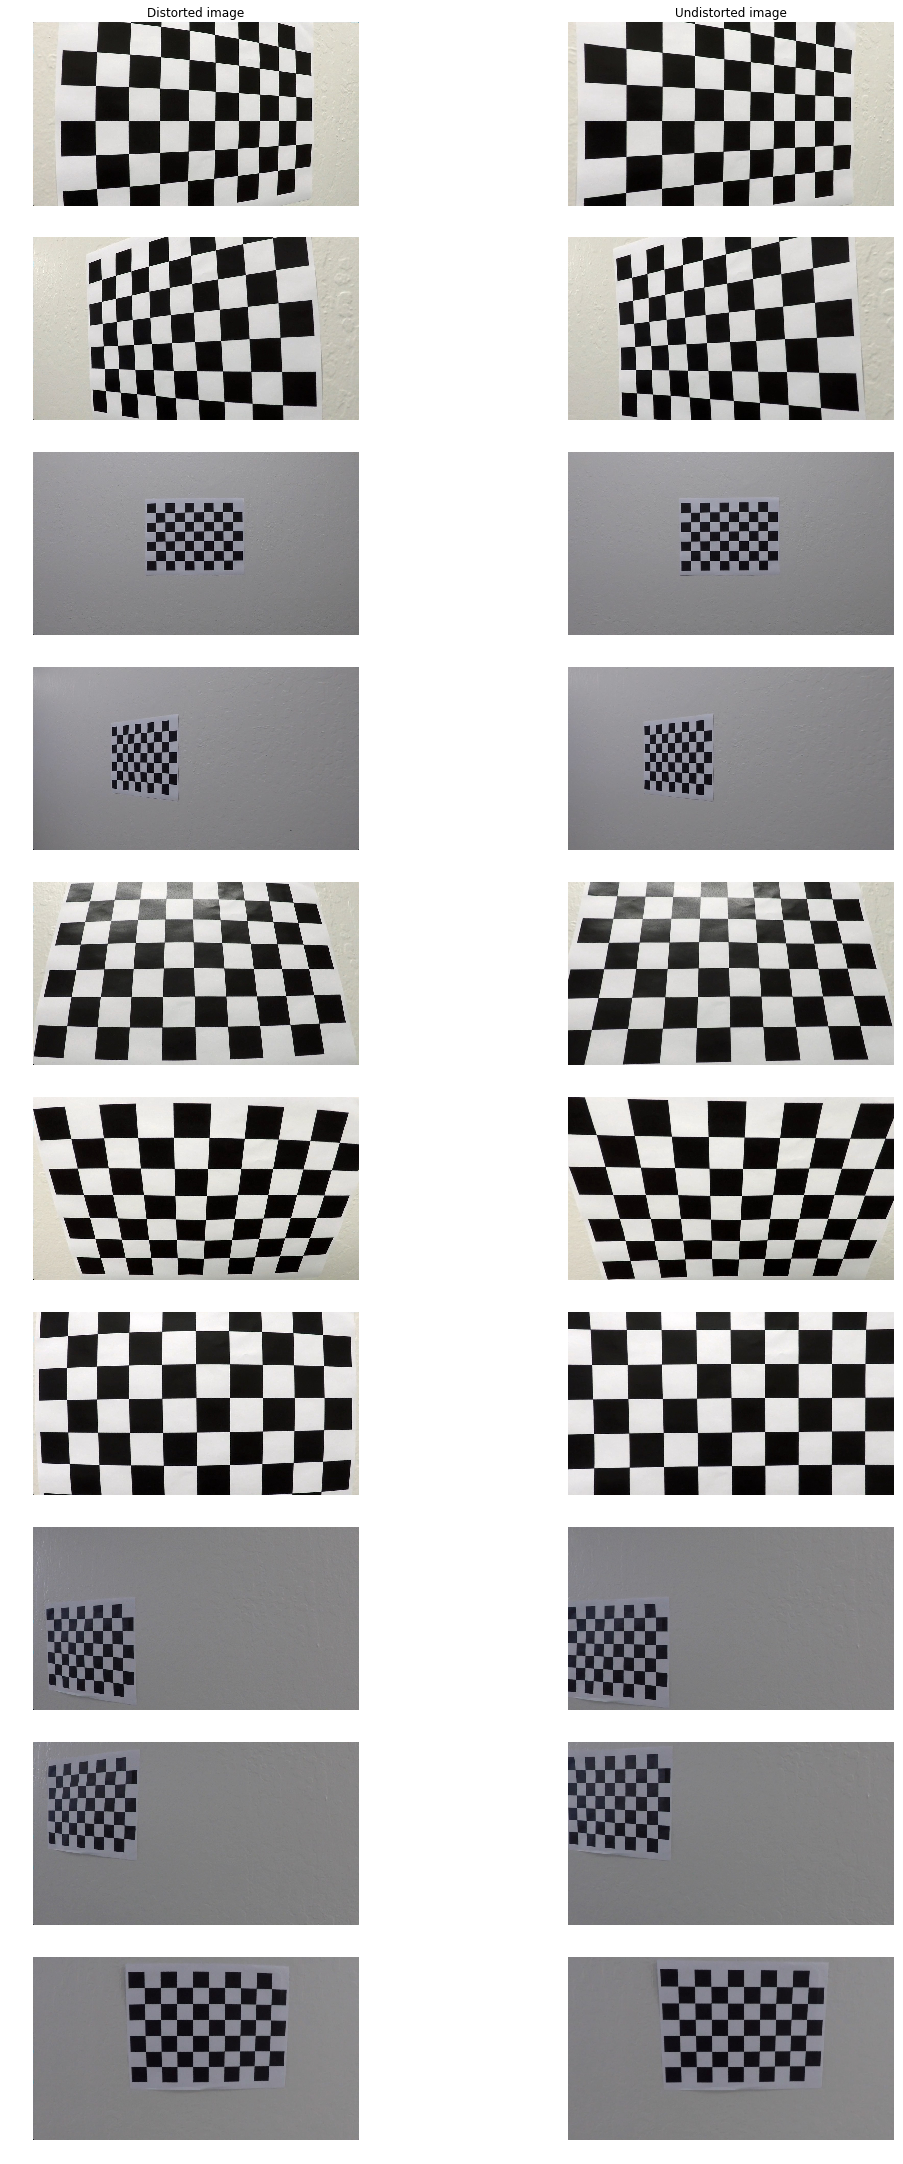

In [5]:
def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


rows = len(images) // 2
columns = 2

fig, ax = plt.subplots(rows, columns)
fig.set_size_inches(15, 30)
fig.tight_layout()

dist_img = mpimg.imread("camera_cal/calibration1.jpg")
undist_img = undist(dist_img)

index = 0

for row in range(rows):
    if row == 0:
        ax[0][0].set_title("Distorted image")
        ax[0][1].set_title("Undistorted image")

    ax[row][0].axis("off")
    ax[row][1].axis("off")
    
    img = mpimg.imread(images[index])
    ax[row][0].imshow(img)
    ax[row][1].imshow(undist(img))
    index += 1

print("Done")


### Example of correction test image

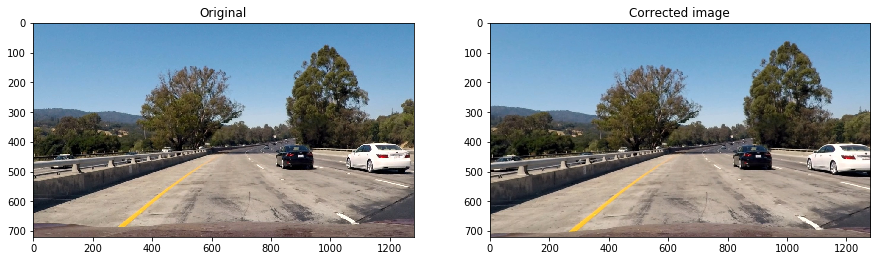

In [6]:
test_img = mpimg.imread("test_images/test1.jpg")
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(15, 30)
ax[0].imshow(test_img)
ax[0].set_title("Original")
ax[1].imshow(undist(test_img))
ax[1].set_title("Corrected image")

##Create threshold binary image. 

There will be used two types of threshold binary image creation and his combination:
- Sobel operator
- Color threshold
- Sobel operator + color threshold

Done


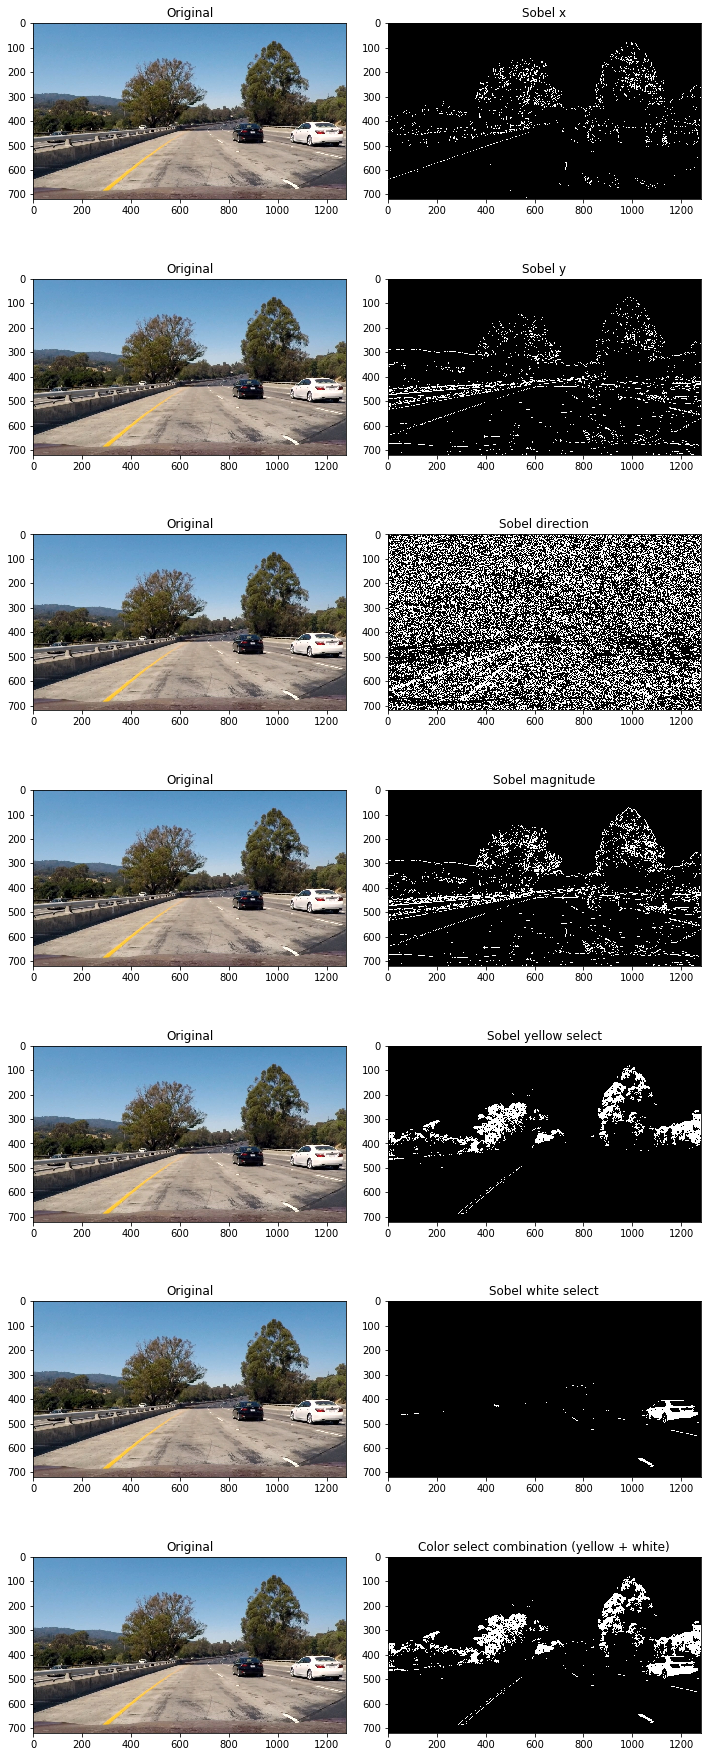

In [7]:
def sobel(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' ororient_x = 0
    orient_y = 0
    if orient == 'x':
        orient_x = 1
        orient_y = 0
    else:
        orient_x = 0
        orient_y = 1

    sobel_img = cv2.Sobel(gray, cv2.CV_64F, orient_x, orient_y, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_img)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled)
    sbinary[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary


def sobel_mag(img, sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)  #x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)  #y
    # 3) Calculate the magnitude 
    sobel_res = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255 * sobel_res / np.max(sobel_res))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def sobel_dir(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s = hls[:, :, 2]
    binary_output = np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20, 60, 60])
    upper = np.array([38, 174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask


def select_white(image):
    lower = np.array([202, 202, 202])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(image, lower, upper)
    return mask


def select_yellow_and_white(image):
    yellow = select_yellow(image)
    white = select_white(image)

    combined_binary = np.zeros_like(yellow)
    combined_binary[(yellow >= 1) | (white >= 1)] = 1

    return combined_binary


test_img = mpimg.imread("test_images/test1.jpg")

sobelx_img = sobel(test_img, orient='x', thresh=(30, 100))
sobely_img = sobel(test_img, orient='y', thresh=(30, 100))
sobel_dir_img = sobel_dir(test_img, sobel_kernel=15, thresh=(0.7, 1.3))
sobel_mag_img = sobel_mag(test_img, sobel_kernel=3, thresh=(30, 100))
sobel_yellow_img = select_yellow(test_img)
sobel_white_img = select_white(test_img)
sobel_comb_img = select_yellow_and_white(test_img)

rows = 7
cols = 2

fig, ax = plt.subplots(rows, cols)

fig.set_size_inches(10, 25)
fig.tight_layout()

for index in range(rows):
    ax[index][0].set_title("Original")
    ax[index][0].imshow(test_img)

ax[0][1].set_title("Sobel x")
ax[0][1].imshow(sobelx_img, cmap='gray')

ax[1][1].set_title("Sobel y")
ax[1][1].imshow(sobely_img, cmap='gray')

ax[2][1].set_title("Sobel direction")
ax[2][1].imshow(sobel_dir_img, cmap='gray')

ax[3][1].set_title("Sobel magnitude")
ax[3][1].imshow(sobel_mag_img, cmap='gray')

ax[4][1].set_title("Sobel yellow select")
ax[4][1].imshow(sobel_yellow_img, cmap='gray')

ax[5][1].set_title("Sobel white select")
ax[5][1].imshow(sobel_white_img, cmap='gray')

ax[6][1].set_title("Color select combination (yellow + white)")
ax[6][1].imshow(sobel_comb_img, cmap='gray')

print("Done")


The most effective method is color select combination (yellow and white)

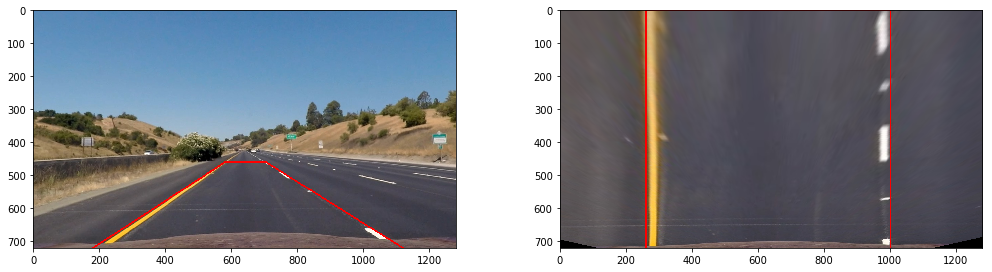

In [9]:
def bird_eye_transform(img, src, dst, width=1280, height=720):
    transform_matrix = cv2.getPerspectiveTransform(src, dst)
    transformed = cv2.warpPerspective(img, transform_matrix, (width, height), flags=cv2.INTER_LINEAR)
    return transformed

src = [[180, 720], [580, 460], [705, 460], [1120, 720]]
dst = [[260, 720], [260, 0], [1000, 0], [1000, 720]]

fig, ax = plt.subplots(1, 2)
fig.tight_layout()
fig.set_size_inches(15, 10)
img = undist(mpimg.imread("test_images/straight_lines1.jpg"))
line_img = np.copy(img)
mask_points = np.array(src, dtype=np.int32).reshape((-1, 1, 2))
dst_line_points = np.array(dst, dtype=np.int32).reshape((-1, 1, 2))

transformed_img = bird_eye_transform(img, np.float32(src), np.float32(dst))

cv2.polylines(line_img, [mask_points], False, (255, 0, 0), thickness=3, lineType=cv2.FILLED)
cv2.polylines(transformed_img, [dst_line_points], False, (255, 0, 0), thickness=3, lineType=cv2.FILLED)

ax[0].imshow(line_img, cmap='gray')
ax[1].imshow(transformed_img, cmap='gray')


## Detect lane pixels and fit to find the lane boundary.

(1280,)


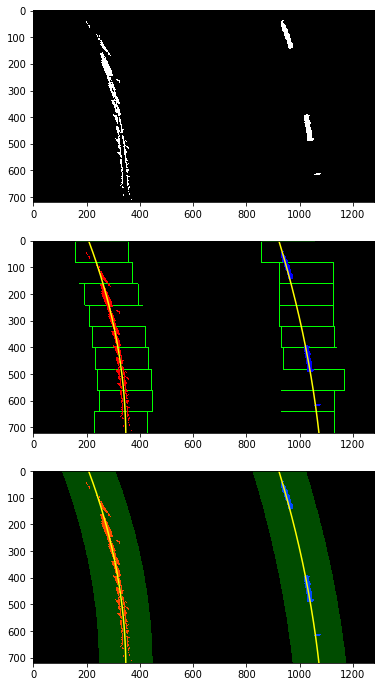

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Transform image and apply gradient threshold
def prepare_image(img):
    undist_img = undist(img)
    binary_warped = bird_eye_transform(undist_img, np.float32(src), np.float32(dst))
    binary_warped = select_yellow_and_white(binary_warped)
    return binary_warped, undist_img

def find_lines(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    print(histogram.shape)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                      (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                      (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   
    return (left_fit, right_fit, left_fitx, right_fitx, ploty, out_img)   

def find_lines_next_frame(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return left_fit, right_fit, left_fitx, right_fitx, ploty, result

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(8, 12)
image = mpimg.imread("test_images/test2.jpg")
binary_warped, undist_img = prepare_image(image)
ax[0].imshow(binary_warped, cmap="gray")

(left_fit, right_fit, left_fitx, right_fitx, ploty, out_img) = find_lines(binary_warped) 
(left_fit, right_fit, left_fitx, right_fitx, ploty, result) = find_lines_next_frame(binary_warped, left_fit, right_fit)   
   
ax[1].imshow(out_img)
ax[1].plot(left_fitx, ploty, color='yellow')
ax[1].plot(right_fitx, ploty, color='yellow')

ax[2].imshow(result)
ax[2].plot(left_fitx, ploty, color='yellow')
ax[2].plot(right_fitx, ploty, color='yellow')



(1280,)
1977.28826226 3814.75357658


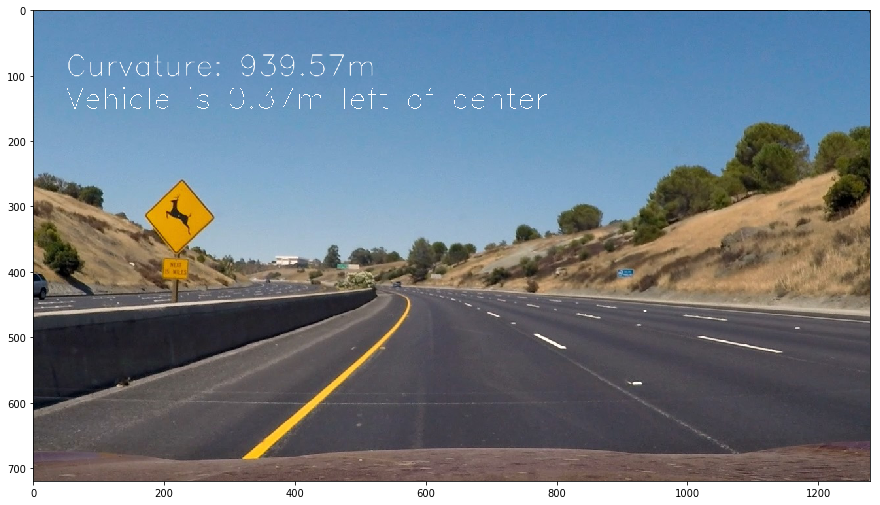

In [13]:
def curvature(left_fit, right_fit, leftx, rightx, ploty):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
    print(left_curverad, right_curverad)

    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    curverad = (left_curverad + right_curverad) / 2

    rightx_int = right_fit[0] * 720 ** 2 + right_fit[1] * 720 + right_fit[2]
    leftx_int = left_fit[0] * 720 ** 2 + left_fit[1] * 720 + left_fit[2]

    position = (rightx_int + leftx_int) / 2
    distance_from_center = abs((640 - position) * xm_per_pix)

    return curverad, distance_from_center, position


def draw_curvature(img, curv, distance_from_center, position):
    cv2.putText(img, "Curvature: {0:.2f}m".format(curv), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255),
                lineType=cv2.LINE_AA)

    # Print distance from center on video
    if position > 640:
        cv2.putText(img, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, (255, 255, 255))
    else:
        cv2.putText(img, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255))
    return img

original_img = mpimg.imread("test_images/test2.jpg")
binary_warped, undist_img = prepare_image(np.copy(original_img))
(left_fit, right_fit, right_fitx, left_fitx, ploty, debug_img) = find_lines(binary_warped)
(curv, distance_from_center, position) = curvature(left_fit, right_fit, left_fitx, right_fitx, ploty)
plt.figure(figsize=(15, 20))
plt.imshow(draw_curvature(original_img, curv, distance_from_center, position))


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


(1280,)
2365.6349891 2227.78239101
(720,)


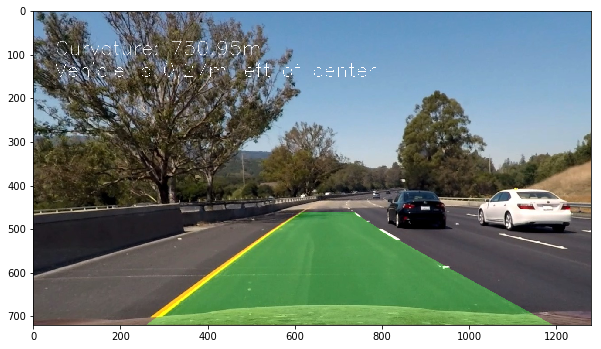

In [15]:
# Create an image to draw the lines on 


def draw_debug_info(image, binary_warped, left_fitx, right_fitx, ploty, curv, distance_from_center, position):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    print(right_fitx.shape)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    transform_matrix = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    newwarp = cv2.warpPerspective(color_warp, transform_matrix, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result = draw_curvature(result, curv, distance_from_center, position)
    return result


def process_pipeline(img):
    binary_warped, undist_img = prepare_image(img)
    (left_fit, right_fit, right_fitx, left_fitx, ploty, debug_img) = find_lines(binary_warped)
    curv, distance_from_center, position = curvature(left_fit, right_fit, right_fitx, left_fitx, ploty)
    img = draw_debug_info(undist_img, binary_warped, left_fitx, right_fitx, ploty, curv, distance_from_center, position)
    return img


original_img = mpimg.imread("test_images/test6.jpg")
plt.figure(figsize=(10, 15))
plt.imshow(process_pipeline(original_img))


In [27]:
challenge_output = 'project_processed.mp4'
clip3 = VideoFileClip('project_video.mp4')
first_frame = clip3.get_frame(0)

(left_fitx, right_fitx, left_line, right_line, ploty, debug_img) = find_lines(prepare_image(first_frame)[0])

def process_pipeline_next(img):
    binary_warped, undist_img = prepare_image(img)
    global left_line, right_line
    (left_line, right_line, left_fitx, right_fitx, ploty, debug_img) = \
        find_lines_next_frame(binary_warped, left_line, right_line)
    return draw_debug_info(undist_img, binary_warped, left_fitx, right_fitx, ploty)


challenge_clip = clip3.fl_image(process_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(1280,)
(1280,)
1724.71695524 2222.88756199
(720,)
[MoviePy] >>>> Building video project_processed.mp4


[MoviePy] Writing video project_processed.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(1280,)


  0%|          | 1/1261 [00:00<02:41,  7.78it/s]

1724.71695524 2222.88756199
(720,)


  0%|          | 2/1261 [00:00<02:48,  7.47it/s]

(1280,)
1947.41343807 2284.78533996
(720,)


  0%|          | 3/1261 [00:00<02:47,  7.49it/s]

(1280,)
2039.26138154 2317.06461645
(720,)


  0%|          | 4/1261 [00:00<02:45,  7.61it/s]

(1280,)
2549.30101593 2222.44507535
(720,)


  0%|          | 5/1261 [00:00<02:52,  7.28it/s]

(1280,)
2052.05512326 2210.75215268
(720,)


(1280,)
1663.80212821 2303.28907818
(720,)


  0%|          | 6/1261 [00:00<02:59,  7.01it/s]

(1280,)
1599.61592315 2339.54624428
(720,)


  1%|          | 7/1261 [00:00<03:02,  6.89it/s]

  1%|          | 8/1261 [00:01<03:33,  5.87it/s]

  1%|          | 9/1261 [00:01<03:14,  6.45it/s]

(1280,)
1522.03675347 3486.71615839
(720,)
(1280,)
1565.04757979 3567.53882214
(720,)


  1%|          | 10/1261 [00:01<03:00,  6.94it/s]

(1280,)
1975.50753084 3584.81530609
(720,)
(1280,)
2505.15691053 3753.2008288
(720,)
(1280,)
2151.64520416 3688.29924586
(720,)

  1%|          | 12/1261 [00:01<02:41,  7.71it/s]

  1%|          | 13/1261 [00:01<02:33,  8.14it/s]

  1%|          | 15/1261 [00:01<02:20,  8.85it/s]


(1280,)
2090.1053292 4271.01886118
(720,)
(1280,)
2531.59025909 3674.61807907
(720,)
(1280,)
2997.90121296 3676.03076913
(720,)


  1%|▏         | 16/1261 [00:02<02:26,  8.52it/s]

(1280,)
2177.2982441 3099.54470314
(720,)
(1280,)
2421.04600346 3076.28923923
(720,)
(1280,)
2882.57701139 

  1%|▏         | 18/1261 [00:02<02:19,  8.91it/s]

  2%|▏         | 19/1261 [00:02<02:30,  8.24it/s]

2973.9771503
(720,)
(1280,)
3294.86956479 3123.56327332
(720,)


  2%|▏         | 20/1261 [00:02<02:27,  8.41it/s]

  2%|▏         | 22/1261 [00:02<02:15,  9.15it/s]

(1280,)
2640.84573326 3225.88885298
(720,)
(1280,)
2473.80171924 3351.2923633
(720,)
(1280,)
2646.67779157 3186.46726388
(720,)


  2%|▏         | 23/1261 [00:02<02:16,  9.09it/s]

  2%|▏         | 25/1261 [00:02<02:05,  9.86it/s]

(1280,)
2553.26320931 3228.45131444
(720,)
(1280,)
4892.84474846 2952.15278256
(720,)
(1280,)
4414.31888959 2886.67878489
(720,)


  2%|▏         | 27/1261 [00:03<02:02, 10.09it/s]

(1280,)
4027.52789295 2375.50489242
(720,)
(1280,)
2841.64209431 2295.94562043
(720,)
(1280,)
2705.89529204 2443.51663307
(720,)


  2%|▏         | 29/1261 [00:03<02:05,  9.80it/s]

  2%|▏         | 31/1261 [00:03<01:56, 10.53it/s]

(1280,)
2081.41748974 2144.39098872
(720,)
(1280,)
1618.66097581 2146.08467865
(720,)
(1280,)
1737.27222033 2208.34702484
(720,)


  3%|▎         | 33/1261 [00:03<01:57, 10.42it/s]

(1280,)
1376.72715748 2112.70898671
(720,)
(1280,)
1537.96890714 2346.92909738
(720,)
(1280,)
1489.56723728 2685.44478816
(720,)


  3%|▎         | 35/1261 [00:03<01:55, 10.60it/s]

  3%|▎         | 37/1261 [00:04<01:46, 11.45it/s]

(1280,)
1626.31641531 2887.5622881
(720,)
(1280,)
1454.54458384 2873.62268679
(720,)
(1280,)
1455.77967717 2494.95535883
(720,)


  3%|▎         | 39/1261 [00:04<01:47, 11.35it/s]

(1280,)
1350.87320585 2314.07166959
(720,)
(1280,)
1272.90438802 2355.78668335
(720,)
(1280,)
1363.06575084 2115.40701503
(720,)


  3%|▎         | 41/1261 [00:04<01:44, 11.72it/s]

  3%|▎         | 43/1261 [00:04<01:39, 12.19it/s]

(1280,)
1464.03434277 2062.83877761
(720,)
(1280,)
1411.17264304 2022.91670438
(720,)
(1280,)
1533.85129135 2043.06248186
(720,)


  4%|▎         | 45/1261 [00:04<01:40, 12.09it/s]

(1280,)
1427.8764205 2100.44489692
(720,)
(1280,)
1558.12333986 1960.5516914
(720,)
(1280,)
1681.36557459 2447.88337774
(720,)


  4%|▎         | 47/1261 [00:04<01:38, 12.36it/s]

(1280,)
1647.20210037 2366.92002776
(720,)
(1280,)
1799.17179965 2368.96168496
(720,)


  4%|▍         | 49/1261 [00:05<01:51, 10.83it/s]

(1280,)
2322.37104006 2489.01628259
(720,)
(1280,)
2711.61385148 2495.56426823
(720,)


  4%|▍         | 51/1261 [00:05<02:09,  9.35it/s]

(1280,)
2870.10566352 2078.25101728
(720,)
(1280,)
2775.79992574 1887.42652464
(720,)


  4%|▍         | 53/1261 [00:05<02:21,  8.54it/s]

  4%|▍         | 54/1261 [00:05<02:29,  8.07it/s]

(1280,)
3011.73747647 1928.0435661
(720,)
(1280,)
4204.9779774 1948.49540615
(720,)


  4%|▍         | 55/1261 [00:05<02:45,  7.29it/s]

(1280,)
4425.0746177 2045.25308065
(720,)
(1280,)
3509.51371187 2118.66423329
(720,)


  4%|▍         | 56/1261 [00:06<02:55,  6.86it/s]

  5%|▍         | 57/1261 [00:06<02:55,  6.85it/s]

(1280,)
2837.02054761 2060.5774541
(720,)
(1280,)
2642.49577004 2208.33650239
(720,)


  5%|▍         | 58/1261 [00:06<03:05,  6.50it/s]

  5%|▍         | 59/1261 [00:06<03:04,  6.53it/s]

(1280,)
2315.30548623 3212.94953205
(720,)
(1280,)
2385.32076831 2898.76503778
(720,)


  5%|▍         | 60/1261 [00:06<03:09,  6.34it/s]

  5%|▍         | 61/1261 [00:06<03:23,  5.89it/s]

(1280,)
2792.76239514 2908.47671047
(720,)
(1280,)
3128.20258221 2865.90757571
(720,)


  5%|▍         | 62/1261 [00:07<03:24,  5.88it/s]

  5%|▍         | 63/1261 [00:07<03:15,  6.14it/s]

  5%|▌         | 65/1261 [00:07<02:45,  7.21it/s]

(1280,)
2462.42100314 2690.69287796
(720,)
(1280,)
2173.38881751 2648.75790527
(720,)
(1280,)
2177.82063746 2814.4863023
(720,)


  5%|▌         | 66/1261 [00:07<02:33,  7.79it/s]

  5%|▌         | 68/1261 [00:07<02:18,  8.61it/s]

(1280,)
2118.27525917 2982.45701948
(720,)
(1280,)
2292.63546913 2872.69612215
(720,)
(1280,)
2018.0720327 3041.41734452
(720,)


  5%|▌         | 69/1261 [00:07<02:16,  8.71it/s]

  6%|▌         | 71/1261 [00:08<02:04,  9.56it/s]

(1280,)
1597.82690064 2926.24691138
(720,)
(1280,)
1385.47003804 3150.0936633
(720,)
(1280,)
1529.16998137 4886.31528705
(720,)


  6%|▌         | 73/1261 [00:08<02:03,  9.65it/s]

(1280,)
1779.13457479 5152.0575061
(720,)
(1280,)
1665.24362344 4574.75000255
(720,)
(1280,)
1401.18200676 4696.96861681


  6%|▌         | 75/1261 [00:08<02:04,  9.53it/s]

(720,)
(1280,)
3250.06999143 4428.54257799
(720,)
(1280,)


  6%|▌         | 76/1261 [00:08<02:04,  9.51it/s]

  6%|▌         | 77/1261 [00:08<02:06,  9.35it/s]

2774.60290467 2687.17627
(720,)
(1280,)
3493.8912072 2652.99068267
(720,)
(1280,)


  6%|▋         | 79/1261 [00:08<02:02,  9.64it/s]

2286.50907533 2699.35803156
(720,)
(1280,)
2245.10680439 2253.56791698
(720,)
(1280,)
2661.34551619 2065.75125807
(720,)


  6%|▋         | 81/1261 [00:09<01:59,  9.86it/s]

  7%|▋         | 83/1261 [00:09<01:51, 10.61it/s]

(1280,)
4085.89001287 2079.65100969
(720,)
(1280,)
3773.41976434 2201.6552007
(720,)
(1280,)
3664.24717476 2305.13103102
(720,)


  7%|▋         | 85/1261 [00:09<01:52, 10.44it/s]

(1280,)
4210.50337376 3498.68207664
(720,)
(1280,)
4748.95463276 3361.61760254
(720,)
(1280,)
4278.11456486 3037.08145443
(720,)


  7%|▋         | 87/1261 [00:09<01:49, 10.68it/s]

  7%|▋         | 89/1261 [00:09<01:44, 11.17it/s]

(1280,)
4940.9926393 3207.75751689
(720,)
(1280,)
3648.23361144 2745.59237999
(720,)
(1280,)
2872.27177626 2634.70609161
(720,)


  7%|▋         | 91/1261 [00:09<01:49, 10.71it/s]

(1280,)
4152.64504253 2257.14343249
(720,)
(1280,)
1689.22758435 2451.51170644
(720,)
(1280,)


  7%|▋         | 93/1261 [00:10<01:51, 10.44it/s]

1467.2939195 2503.40752993
(720,)
(1280,)
1394.00303825 2454.93794033
(720,)
(1280,)
1513.11870007 2486.12232362
(720,)


  8%|▊         | 95/1261 [00:10<01:50, 10.58it/s]

  8%|▊         | 97/1261 [00:10<01:44, 11.15it/s]

(1280,)
1627.81502878 2611.12005756
(720,)
(1280,)
1241.24799279 2846.14806025
(720,)
(1280,)
1790.36308414 2926.69431935
(720,)


  8%|▊         | 99/1261 [00:10<01:43, 11.18it/s]

(1280,)
2272.22945026 3030.89466078
(720,)
(1280,)
2599.41471442 2866.29403134
(720,)
(1280,)
3325.88314288 2835.5873961
(720,)


  8%|▊         | 101/1261 [00:10<01:45, 10.99it/s]

  8%|▊         | 103/1261 [00:10<01:41, 11.44it/s]

(1280,)
2158.7480721 1832.8901692
(720,)
(1280,)
4286.16488716 1800.28211564
(720,)
(1280,)
1836.17589263 1793.72188783
(720,)


  8%|▊         | 105/1261 [00:11<01:43, 11.22it/s]

(1280,)
1890.99570447 1982.14804318
(720,)
(1280,)
2918.14906656 2112.57074828
(720,)
(1280,)
4201.44883154 2220.47043567
(720,)


  8%|▊         | 107/1261 [00:11<01:45, 10.98it/s]

  9%|▊         | 109/1261 [00:11<01:41, 11.40it/s]

(1280,)
1759.70293657 2288.28969006
(720,)
(1280,)
1776.24893085 2321.52472873
(720,)
(1280,)
1848.05479332 3234.3331313
(720,)


  9%|▉         | 111/1261 [00:11<01:41, 11.36it/s]

(1280,)
1779.38509898 3109.42995688
(720,)
(1280,)
1561.07030346 3286.65415265
(720,)
(1280,)
1513.18809367 3347.07448196
(720,)


  9%|▉         | 113/1261 [00:11<01:43, 11.04it/s]

  9%|▉         | 115/1261 [00:12<01:39, 11.49it/s]

(1280,)
1635.34927915 3329.64570995
(720,)
(1280,)
1699.47109849 3135.398986
(720,)
(1280,)
1569.17673782 2766.73043863
(720,)


  9%|▉         | 117/1261 [00:12<01:41, 11.28it/s]

(1280,)
1765.95435095 1708.97525401
(720,)
(1280,)
2149.69225915 1763.87677033
(720,)
(1280,)
2361.04867211 1704.01945415
(720,)


  9%|▉         | 119/1261 [00:12<01:42, 11.09it/s]

 10%|▉         | 121/1261 [00:12<01:39, 11.40it/s]

(1280,)
1717.4291467 1712.89047481
(720,)
(1280,)
2247.88020705 1625.46924962
(720,)
(1280,)
1981.55376735 1640.81548864
(720,)


 10%|▉         | 123/1261 [00:12<01:40, 11.36it/s]

(1280,)
1368.27307773 1821.1753651
(720,)
(1280,)
1493.60240864 1841.12346237
(720,)
(1280,)
1658.41392871 1826.41619077
(720,)


 10%|▉         | 125/1261 [00:12<01:41, 11.20it/s]

 10%|█         | 127/1261 [00:13<01:37, 11.66it/s]

(1280,)
1848.00867959 1773.22996474
(720,)
(1280,)
1709.17037877 1673.91322662
(720,)
(1280,)
1597.09189791 1604.47584271
(720,)


 10%|█         | 129/1261 [00:13<01:42, 11.05it/s]

(1280,)
2266.83634554 1665.36198295
(720,)
(1280,)
2300.96869471 1761.69522923
(720,)
(1280,)
1736.80744943 1802.4193519
(720,)


 10%|█         | 131/1261 [00:13<01:41, 11.11it/s]

 11%|█         | 133/1261 [00:13<01:37, 11.53it/s]

(1280,)
1835.15558194 1873.74947445
(720,)
(1280,)
1774.89921577 1870.20889949
(720,)
(1280,)
1953.86785851 1942.96362609
(720,)


 11%|█         | 135/1261 [00:13<01:40, 11.25it/s]

(1280,)
2600.39954679 2280.04611669
(720,)
(1280,)
1993.54190833 2267.74878394
(720,)
(1280,)
2375.92348447 2448.11860863
(720,)


 11%|█         | 137/1261 [00:14<01:40, 11.14it/s]

 11%|█         | 139/1261 [00:14<01:36, 11.63it/s]

(1280,)
2393.54319545 2496.00993941
(720,)
(1280,)
2367.04827306 2483.3293566
(720,)
(1280,)
2577.44849912 2414.48607587
(720,)


 11%|█         | 141/1261 [00:14<01:40, 11.10it/s]

(1280,)
3065.67220043 2356.26321312
(720,)
(1280,)
3081.53443381 2490.6738507
(720,)
(1280,)
3334.6109017 2673.6579478
(720,)


 11%|█▏        | 143/1261 [00:14<01:39, 11.28it/s]

 11%|█▏        | 145/1261 [00:14<01:35, 11.72it/s]

(1280,)
3552.89227151 2714.29851254
(720,)
(1280,)
2670.30206716 2684.38197459
(720,)
(1280,)
2555.37455533 2787.95330781
(720,)


 12%|█▏        | 147/1261 [00:14<01:37, 11.38it/s]

(1280,)
2239.66458903 2909.48257687
(720,)
(1280,)
2422.97871641 4719.29869574
(720,)
(1280,)
6860.87373398 4663.99696358
(720,)


 12%|█▏        | 149/1261 [00:15<01:36, 11.48it/s]

 12%|█▏        | 151/1261 [00:15<01:33, 11.93it/s]

(1280,)
18127.3157487 4370.78412946
(720,)
(1280,)
4022.55479708 4580.94023634
(720,)
(1280,)
2702464.49372 3069.1075321
(720,)


 12%|█▏        | 153/1261 [00:15<01:36, 11.43it/s]

(1280,)
4299.98150424 3267.41482988
(720,)
(1280,)
3698.95122982 2133.50137567
(720,)
(1280,)
2637.62435591 2114.73417303
(720,)


 12%|█▏        | 155/1261 [00:15<01:37, 11.40it/s]

 12%|█▏        | 157/1261 [00:15<01:33, 11.77it/s]

(1280,)
2294.52703795 2195.75652413
(720,)
(1280,)
3842.7389467 2209.16326611
(720,)
(1280,)
2021.97408361 2182.79238074
(720,)


 13%|█▎        | 159/1261 [00:15<01:36, 11.39it/s]

(1280,)
1798.29568416 2061.64916306
(720,)
(1280,)
1750.47833711 2814.73922436
(720,)
(1280,)
1826.10865358 2935.93281525
(720,)


 13%|█▎        | 161/1261 [00:16<01:35, 11.47it/s]

 13%|█▎        | 163/1261 [00:16<01:32, 11.82it/s]

(1280,)
1783.31466871 3021.81970312
(720,)
(1280,)
1910.3242166 3129.49114357
(720,)
(1280,)
2054.88268025 3407.59691611
(720,)


 13%|█▎        | 165/1261 [00:16<01:35, 11.48it/s]

(1280,)
2226.36813403 4020.81771774
(720,)
(1280,)
1469.64340494 2651.6591054
(720,)
(1280,)
2113.87553777 2749.23803018
(720,)


 13%|█▎        | 167/1261 [00:16<01:34, 11.56it/s]

 13%|█▎        | 169/1261 [00:16<01:32, 11.86it/s]

(1280,)
2049.96307317 2588.04197799
(720,)
(1280,)
2034.32706708 2744.92995898
(720,)
(1280,)
1496.4707781 2743.8536917
(720,)


 14%|█▎        | 171/1261 [00:16<01:34, 11.53it/s]

(1280,)
1914.07906415 2674.18236242
(720,)
(1280,)
2086.0723769 2457.85103816
(720,)
(1280,)
1482.61038613 2181.59151142
(720,)


 14%|█▎        | 173/1261 [00:17<01:34, 11.50it/s]

 14%|█▍        | 175/1261 [00:17<01:32, 11.76it/s]

(1280,)
1313.79059437 2047.82339749
(720,)
(1280,)
1241.82763896 2122.02638118
(720,)
(1280,)
4206.37337508 1962.0840199
(720,)


 14%|█▍        | 177/1261 [00:17<01:34, 11.42it/s]

(1280,)
5735.43863872 1354.97912126
(720,)
(1280,)
4013.30201653 1519.21555652
(720,)
(1280,)
2719.2742011 1547.15678478
(720,)


 14%|█▍        | 179/1261 [00:17<01:34, 11.49it/s]

 14%|█▍        | 181/1261 [00:17<01:32, 11.68it/s]

(1280,)
3047.11862243 1440.22497295
(720,)
(1280,)
2069.28039363 1375.86530429
(720,)
(1280,)
1779.59501703 1234.80040976
(720,)


 15%|█▍        | 183/1261 [00:17<01:33, 11.52it/s]

(1280,)
1866.60963298 1284.32701546
(720,)
(1280,)
1826.25358855 1258.04214722
(720,)
(1280,)
1574.95570232 1463.5113915
(720,)


 15%|█▍        | 185/1261 [00:18<01:33, 11.51it/s]

 15%|█▍        | 187/1261 [00:18<01:32, 11.58it/s]

(1280,)
1485.53858555 1390.98951244
(720,)
(1280,)
1410.42257946 1359.48508736
(720,)
(1280,)
1480.60236406 1420.55618402
(720,)


 15%|█▍        | 189/1261 [00:18<01:33, 11.43it/s]

(1280,)
1284.99399878 1418.75072707
(720,)
(1280,)
1105.90756051 1391.34233678
(720,)
(1280,)
1391.54355699 1425.74307384
(720,)


 15%|█▌        | 191/1261 [00:18<01:33, 11.45it/s]

(1280,)
1390.98445727 1641.64141018
(720,)
(1280,)
1280.32332501 1678.99392276
(720,)
(1280,)
1386.56983981 1790.86791045
(720,)


 15%|█▌        | 193/1261 [00:18<01:33, 11.36it/s]

 15%|█▌        | 195/1261 [00:19<01:38, 10.83it/s]

(1280,)
1794.47589117 1889.81236515
(720,)
(1280,)
2241.02142988 1824.28071298
(720,)
(1280,)
2183.10010427 2278.3695712
(720,)


 16%|█▌        | 197/1261 [00:19<01:40, 10.55it/s]

(1280,)
2536.59649199 2507.55841803
(720,)
(1280,)
2824.82249956 2705.43045163
(720,)


 16%|█▌        | 199/1261 [00:19<01:51,  9.49it/s]

 16%|█▌        | 200/1261 [00:19<01:58,  8.92it/s]

(1280,)
2483.41021086 2869.47828152
(720,)
(1280,)
2315.27663247 2620.99945621
(720,)


 16%|█▌        | 201/1261 [00:19<01:59,  8.87it/s]

(1280,)
2778.54060851 2530.75296665
(720,)
(1280,)
2434.19429669 2534.10595234
(720,)
(1280,)

 16%|█▌        | 203/1261 [00:19<01:55,  9.15it/s]


3847.96448651 2443.53819615
(720,)
(1280,)
2730.56935297 2292.04831301
(720,)
(1280,)
1911.09223754 2025.14425776
(720,)


 16%|█▋        | 205/1261 [00:20<01:50,  9.53it/s]

 16%|█▋        | 207/1261 [00:20<01:48,  9.76it/s]

(1280,)
2348.08925556 2010.61830485
(720,)
(1280,)
1867.19594688 1821.01677674
(720,)
(1280,)


 17%|█▋        | 209/1261 [00:20<01:44, 10.03it/s]

1358.68774695 2383.41823031
(720,)
(1280,)
1767.74004431 2073.03657504
(720,)
(1280,)

 17%|█▋        | 211/1261 [00:20<01:52,  9.37it/s]


1524.35098861 2192.9162893
(720,)
(1280,)
1338.30916294 2210.69418936
(720,)


 17%|█▋        | 212/1261 [00:20<02:16,  7.68it/s]

(1280,)
1371.56610009 2170.93420809
(720,)
(1280,)
1485.18454331 1827.99232307
(720,)
(1280,)


 17%|█▋        | 214/1261 [00:21<02:05,  8.32it/s]

1453.72395168 1943.67622631
(720,)
(1280,)
1400.37385301 1856.03012728
(720,)


 17%|█▋        | 215/1261 [00:21<02:31,  6.91it/s]

 17%|█▋        | 216/1261 [00:21<02:25,  7.19it/s]

 17%|█▋        | 217/1261 [00:21<02:18,  7.52it/s]

(1280,)
1433.54958686 1975.96347741
(720,)
(1280,)
1436.18854826 2373.99630738
(720,)


 17%|█▋        | 218/1261 [00:21<02:19,  7.50it/s]

 17%|█▋        | 219/1261 [00:21<02:11,  7.94it/s]

(1280,)
1418.72207633 2482.4439229
(720,)
(1280,)
1604.10809007 2363.75685661
(720,)


 17%|█▋        | 220/1261 [00:21<02:11,  7.90it/s]

(1280,)
1429.37855012 2628.37555396
(720,)
(1280,)
1338.42078793 4460.8269483


 18%|█▊        | 221/1261 [00:22<02:59,  5.79it/s]

(720,)


 18%|█▊        | 222/1261 [00:22<03:14,  5.35it/s]

(1280,)
2144.63162001 4371.97554191
(720,)
(1280,)


 18%|█▊        | 223/1261 [00:22<03:10,  5.45it/s]

 18%|█▊        | 224/1261 [00:22<02:50,  6.10it/s]

2117.26093612 4147.81484046
(720,)
(1280,)
1091.80466624 4335.79006941
(720,)


 18%|█▊        | 225/1261 [00:22<02:34,  6.69it/s]

 18%|█▊        | 227/1261 [00:23<02:14,  7.69it/s]

(1280,)
1666.04023385 6545.29395482
(720,)
(1280,)
1621.03342354 5507.08703466
(720,)
(1280,)
2361.8212197 3498.19537223
(720,)


 18%|█▊        | 229/1261 [00:23<02:02,  8.40it/s]

(1280,)
2457.67355949 2996.53276809
(720,)
(1280,)
3109.45969048 2674.30028051
(720,)
(1280,)
2980.22200919 2637.00229888
(720,)


 18%|█▊        | 231/1261 [00:23<01:52,  9.18it/s]

 18%|█▊        | 233/1261 [00:23<01:43,  9.92it/s]

(1280,)
2235.41780199 2531.95311243
(720,)
(1280,)
3210.59116544 2475.0829987
(720,)
(1280,)
1623.36345241 2615.62498473
(720,)


 19%|█▊        | 235/1261 [00:23<01:37, 10.56it/s]

(1280,)
1516.25098004 2943.75009912
(720,)
(1280,)
1369.81362812 2650.70748168
(720,)
(1280,)
1395.92465527 2551.97424651
(720,)


 19%|█▉        | 237/1261 [00:23<01:31, 11.22it/s]

 19%|█▉        | 239/1261 [00:24<01:26, 11.75it/s]

(1280,)
2618.21517129 1895.23518498
(720,)
(1280,)
1377.68681943 2024.27566539
(720,)
(1280,)
1734.95163952 1953.17828693
(720,)


 19%|█▉        | 241/1261 [00:24<01:24, 12.05it/s]

(1280,)
1395.53795179 1867.48813016
(720,)
(1280,)
2777.95200404 1675.052925
(720,)
(1280,)
7347.11096623 1801.34545561
(720,)


 19%|█▉        | 243/1261 [00:24<01:21, 12.57it/s]

 19%|█▉        | 245/1261 [00:24<01:19, 12.73it/s]

(1280,)
4065.07199033 1691.68525095
(720,)
(1280,)
4079.91203727 1699.29700475
(720,)
(1280,)
1856.09166691 2224.25360954
(720,)


 20%|█▉        | 247/1261 [00:24<01:18, 12.93it/s]

(1280,)
2031.61389074 2076.77935847
(720,)
(1280,)
1908.41794802 2165.79628386
(720,)
(1280,)
1905.29974865 2216.44710222
(720,)


 20%|█▉        | 249/1261 [00:24<01:17, 13.00it/s]

 20%|█▉        | 251/1261 [00:24<01:16, 13.23it/s]

(1280,)
1759.73941484 1870.9135324
(720,)
(1280,)
1482.52150193 1895.65618096
(720,)
(1280,)
2018.69810087 1844.05468068
(720,)


 20%|██        | 253/1261 [00:25<01:16, 13.16it/s]

(1280,)
1343.33433548 2008.487497
(720,)
(1280,)
1505.4110473 1983.46825925
(720,)
(1280,)
1297.68400463 2036.42563937
(720,)


 20%|██        | 255/1261 [00:25<01:15, 13.27it/s]

 20%|██        | 257/1261 [00:25<01:15, 13.23it/s]

(1280,)
1487.00000406 1968.75525518
(720,)
(1280,)
1568.6429376 2046.43485158
(720,)
(1280,)
2906.31880807 2714.07760896
(720,)


 21%|██        | 259/1261 [00:25<01:15, 13.36it/s]

(1280,)
2013.98354623 2819.2171934
(720,)
(1280,)
1933.42557004 2742.96285804
(720,)
(1280,)
1500.23937286 2722.51486108
(720,)


 21%|██        | 261/1261 [00:25<01:13, 13.57it/s]

 21%|██        | 263/1261 [00:25<01:13, 13.59it/s]

(1280,)
1748.92312445 2789.06957086
(720,)
(1280,)
3520.98498837 2202.04876239
(720,)
(1280,)
2198.31890443 1733.85713051
(720,)


 21%|██        | 265/1261 [00:25<01:14, 13.44it/s]

(1280,)
1557.31002249 1813.24223801
(720,)
(1280,)
1945.52771553 1866.50770077
(720,)
(1280,)
2591.34438343 1996.80695183
(720,)


 21%|██        | 267/1261 [00:26<01:12, 13.67it/s]

 21%|██▏       | 269/1261 [00:26<01:12, 13.62it/s]

(1280,)
2354.2333887 1984.56023285
(720,)
(1280,)
1140.88951636 2019.21172983
(720,)
(1280,)
1926.7572861 2085.77007462
(720,)


 21%|██▏       | 271/1261 [00:26<01:12, 13.67it/s]

(1280,)
1693.8179201 2663.61747232
(720,)
(1280,)
1255.12626864 2618.92951471
(720,)
(1280,)
1216.45004131 2514.37683566
(720,)


 22%|██▏       | 273/1261 [00:26<01:12, 13.54it/s]

 22%|██▏       | 275/1261 [00:26<01:12, 13.57it/s]

(1280,)
1712.12965915 2529.81016575
(720,)
(1280,)
1946.73139332 2233.23364103
(720,)
(1280,)
2311.56855216 2324.18084587
(720,)


 22%|██▏       | 277/1261 [00:26<01:12, 13.54it/s]

(1280,)
1801.73169634 2447.20231234
(720,)
(1280,)
1802.20574699 2492.20032496
(720,)
(1280,)
2377.57868953 2499.22100853
(720,)


 22%|██▏       | 279/1261 [00:27<01:11, 13.76it/s]

 22%|██▏       | 281/1261 [00:27<01:11, 13.70it/s]

(1280,)
2038.01347493 2458.81527411
(720,)
(1280,)
2640.76875197 2414.12909452
(720,)
(1280,)
2161.37647153 2980.87344613
(720,)


 22%|██▏       | 283/1261 [00:27<01:13, 13.32it/s]

(1280,)
3088.37734699 3109.72059119
(720,)
(1280,)
1718.79420578 3291.76431166
(720,)
(1280,)
2971.32549461 3279.06646826
(720,)


 23%|██▎       | 285/1261 [00:27<01:12, 13.38it/s]

 23%|██▎       | 287/1261 [00:27<01:12, 13.35it/s]

(1280,)
2236.56556665 3228.19391898
(720,)
(1280,)
2317.14119177 3450.97629872
(720,)
(1280,)
2278.99964536 3804.28114396
(720,)


 23%|██▎       | 289/1261 [00:27<01:14, 13.12it/s]

(1280,)
8473.254796 3824.56582446
(720,)
(1280,)
30017.8668384 3172.14084495
(720,)
(1280,)
3201.09331177 3186.80418795
(720,)


 23%|██▎       | 291/1261 [00:27<01:14, 13.05it/s]

 23%|██▎       | 293/1261 [00:28<01:15, 12.83it/s]

(1280,)
3597.88484168 3124.75567478
(720,)
(1280,)
2665.16007652 3111.55994542
(720,)
(1280,)
2928.13534161 3652.07690276
(720,)


 23%|██▎       | 295/1261 [00:28<01:15, 12.75it/s]

(1280,)
48350.6781918 3870.2339651
(720,)
(1280,)
3562.42611387 3700.70198677
(720,)
(1280,)
13065.5514682 3818.44154539
(720,)


 24%|██▎       | 297/1261 [00:28<01:13, 13.08it/s]

 24%|██▎       | 299/1261 [00:28<01:14, 12.90it/s]

(1280,)
3807.4477927 3578.76736908
(720,)
(1280,)
5466.54062081 3006.07691232
(720,)
(1280,)
4847.30638551 2880.90533206
(720,)


 24%|██▍       | 301/1261 [00:28<01:14, 12.97it/s]

(1280,)
5720.84184074 3145.12861892
(720,)
(1280,)
3831.37905447 3381.2664719
(720,)
(1280,)
8355.72840022 3579.26717415
(720,)


 24%|██▍       | 303/1261 [00:28<01:13, 13.09it/s]

 24%|██▍       | 305/1261 [00:29<01:14, 12.85it/s]

(1280,)
17614.5665708 3647.86101437
(720,)
(1280,)
36331.7436627 3689.37846863
(720,)
(1280,)
26000.0729998 7554.54645713
(720,)


 24%|██▍       | 307/1261 [00:29<01:14, 12.73it/s]

(1280,)
6114.1506709 7666.38429117
(720,)
(1280,)
5441.88751405 10450.9374116
(720,)
(1280,)
3451.44534978 9397.4582044
(720,)


 25%|██▍       | 309/1261 [00:29<01:13, 12.90it/s]

 25%|██▍       | 311/1261 [00:29<01:13, 12.92it/s]

(1280,)
3235.75797509 9816.62776565
(720,)
(1280,)
18169.2475738 12569.0013579
(720,)
(1280,)
4686.96985606 30371.3763716
(720,)


 25%|██▍       | 313/1261 [00:29<01:13, 12.97it/s]

(1280,)
136801.039547 21361.6457981
(720,)
(1280,)
23166.4612645 20433.2631578
(720,)
(1280,)
14578.6557237 20694.2515226
(720,)


 25%|██▍       | 315/1261 [00:29<01:11, 13.15it/s]

 25%|██▌       | 317/1261 [00:29<01:12, 13.08it/s]

(1280,)
8977.43741017 23773.9923196
(720,)
(1280,)
37367.8619613 23106.522215
(720,)
(1280,)
3330.89639381 35254.2222553
(720,)


 25%|██▌       | 319/1261 [00:30<01:12, 12.98it/s]

(1280,)
15114.5153162 22665.3272648
(720,)
(1280,)
3254.90284804 39641.6499002
(720,)
(1280,)
7523.23538928 22220.7301697
(720,)


 25%|██▌       | 321/1261 [00:30<01:11, 13.08it/s]

 26%|██▌       | 323/1261 [00:30<01:13, 12.79it/s]

(1280,)
19778.6324967 29906.1341874
(720,)
(1280,)
2590.84068841 4460.87171721
(720,)
(1280,)
3661.87892676 4578.38897243
(720,)


 26%|██▌       | 325/1261 [00:30<01:13, 12.80it/s]

(1280,)
4030.15058378 4984.70074515
(720,)
(1280,)
4941.20891895 5096.24477346
(720,)
(1280,)
2921.9823871 5148.85890212
(720,)


 26%|██▌       | 327/1261 [00:30<01:13, 12.70it/s]

 26%|██▌       | 329/1261 [00:30<01:12, 12.83it/s]

(1280,)
2546.25352073 5225.41552441
(720,)
(1280,)
3541.34729558 5366.8927784
(720,)
(1280,)
14349.3268468 11006.1464087
(720,)


 26%|██▌       | 331/1261 [00:31<01:12, 12.81it/s]

(1280,)
11064.4120976 10864.7717326
(720,)
(1280,)
30040.1436676 12505.4700342
(720,)
(1280,)
14730.6290283 9799.24328116
(720,)


 26%|██▋       | 333/1261 [00:31<01:10, 13.16it/s]

 27%|██▋       | 335/1261 [00:31<01:11, 12.89it/s]

(1280,)
16531.0831261 9867.62949874
(720,)
(1280,)
6064.40068049 11842.959155
(720,)
(1280,)
6125.90006736 12073.3638093
(720,)


 27%|██▋       | 337/1261 [00:31<01:11, 12.86it/s]

(1280,)
5047.75601587 11752.7920837
(720,)
(1280,)
226862.256777 13428.8544297
(720,)
(1280,)
73493.4508815 14203.4675496
(720,)


 27%|██▋       | 339/1261 [00:31<01:10, 13.12it/s]

 27%|██▋       | 341/1261 [00:31<01:10, 13.03it/s]

(1280,)
23644.8598614 19535.3854775
(720,)
(1280,)
17097.183863 20644.1660333
(720,)
(1280,)
7352.44610118 24225.125101
(720,)


 27%|██▋       | 343/1261 [00:31<01:11, 12.84it/s]

(1280,)
60564.6568108 9873.57685324
(720,)
(1280,)
11647.7859772 9363.40364234
(720,)
(1280,)
31598.024333 11441.4128083
(720,)


 27%|██▋       | 345/1261 [00:32<01:10, 13.04it/s]

 28%|██▊       | 347/1261 [00:32<01:11, 12.84it/s]

(1280,)
13007.8600791 10124.5122753
(720,)
(1280,)
11843.4782767 21860.4156644
(720,)
(1280,)
216608.59401 12422.8757827
(720,)


 28%|██▊       | 349/1261 [00:32<01:11, 12.84it/s]

(1280,)
8205.03535671 13535.4622905
(720,)
(1280,)
6860.46452331 21595.1409001
(720,)
(1280,)
246970.130023 22888.6395956
(720,)


 28%|██▊       | 351/1261 [00:32<01:10, 12.94it/s]

 28%|██▊       | 353/1261 [00:32<01:10, 12.93it/s]

(1280,)
39358.4640959 24968.9264897
(720,)
(1280,)
9343.42678557 30111.6313545
(720,)
(1280,)
6269.59161031 86499.87595
(720,)


 28%|██▊       | 355/1261 [00:32<01:10, 12.81it/s]

(1280,)
6664.44775436 15098.6919599
(720,)
(1280,)
6801.40355834 14305.6104942
(720,)
(1280,)
2873.47820261 18437.0098524
(720,)


 28%|██▊       | 357/1261 [00:33<01:08, 13.15it/s]

 28%|██▊       | 359/1261 [00:33<01:09, 12.97it/s]

(1280,)
2593.82876633 16248.1825929
(720,)
(1280,)
2420.03420096 14213.6220531
(720,)
(1280,)
2059.65206932 7544.91465817
(720,)


 29%|██▊       | 361/1261 [00:33<01:10, 12.81it/s]

(1280,)
1646.60464082 8565.39353224
(720,)
(1280,)
4864.59360097 8602.74909751
(720,)
(1280,)
3808.96427317 9003.06757297
(720,)


 29%|██▉       | 363/1261 [00:33<01:09, 12.91it/s]

 29%|██▉       | 365/1261 [00:33<01:09, 12.91it/s]

(1280,)
96256.7315259 9493.17590852
(720,)
(1280,)
4791.81662881 9116.85333773
(720,)
(1280,)
6816.27144241 70985.4407327
(720,)


 29%|██▉       | 367/1261 [00:33<01:10, 12.75it/s]

(1280,)
1946.38345638 87661.0972082
(720,)
(1280,)
6040.38588947 78144.083587
(720,)
(1280,)
3439.68408268 117341.831791
(720,)


 29%|██▉       | 369/1261 [00:33<01:09, 12.87it/s]

 29%|██▉       | 371/1261 [00:34<01:10, 12.69it/s]

(1280,)
2140.26747164 668676.591944
(720,)
(1280,)
2680.54993986 26055.5179429
(720,)
(1280,)
4409.78375076 12641.6427926
(720,)


 30%|██▉       | 373/1261 [00:34<01:15, 11.70it/s]

(1280,)
2692.20332738 20174.7507906
(720,)
(1280,)
2529.77428058 21977.3725087
(720,)
(1280,)

 30%|██▉       | 375/1261 [00:34<01:16, 11.51it/s]


4197.46207247 31861.9125009
(720,)
(1280,)
3408.86411186 34559.2776476
(720,)
(1280,)
17385.0832144 36364.549129
(720,)


 30%|██▉       | 377/1261 [00:34<01:13, 12.02it/s]

(1280,)
15494.7828888 8094.02537418
(720,)
(1280,)
6978.166769 9058.11960156
(720,)
(1280,)


 30%|███       | 379/1261 [00:34<01:18, 11.17it/s]

4283.92430719 7964.24841116
(720,)
(1280,)
4741.95951611 9071.02715408
(720,)
(1280,)


 30%|███       | 381/1261 [00:35<01:21, 10.77it/s]

147331.618999 9178.40963899
(720,)
(1280,)
6734.83237547 10319.0122401
(720,)
(1280,)


 30%|███       | 383/1261 [00:35<01:25, 10.30it/s]

4453.64925277 43232.096089
(720,)
(1280,)
5198.77158582 115904.185052
(720,)
(1280,)

 31%|███       | 385/1261 [00:35<01:26, 10.07it/s]


2097.15842136 109125.788735
(720,)
(1280,)
1900.45283364 138776.682157
(720,)
(1280,)


 31%|███       | 387/1261 [00:35<01:28,  9.88it/s]

 31%|███       | 388/1261 [00:35<01:31,  9.51it/s]

9482.72633685 223437.860698
(720,)
(1280,)
8435.99578262 523298.570844
(720,)


 31%|███       | 390/1261 [00:36<01:30,  9.65it/s]

(1280,)
9331.08002704 69518.1112265
(720,)
(1280,)
145018.115995 10136.5672316
(720,)
(1280,)

 31%|███       | 391/1261 [00:36<01:31,  9.53it/s]

 31%|███       | 392/1261 [00:36<01:35,  9.13it/s]


8340.13593308 11809.3639033
(720,)
(1280,)
7873.01233222 11586.5984842
(720,)


 31%|███       | 393/1261 [00:36<01:34,  9.16it/s]

 31%|███       | 394/1261 [00:36<01:41,  8.58it/s]

(1280,)
8531.07044218 11284.5215843
(720,)
(1280,)
7525.35668323 34588.1839864
(720,)


 31%|███▏      | 396/1261 [00:36<01:34,  9.15it/s]

(1280,)
5398.04375418 26660.3799384
(720,)
(1280,)
4947.53416357 80991.3180912
(720,)
(1280,)
2695.10300447 32793.4422166
(720,)


 32%|███▏      | 398/1261 [00:36<01:32,  9.38it/s]

(1280,)
4821.18295976 42325.0689973
(720,)
(1280,)
5724.84881388 25283.2040956
(720,)
(1280,)


 32%|███▏      | 400/1261 [00:37<01:29,  9.62it/s]

 32%|███▏      | 401/1261 [00:37<01:31,  9.39it/s]

3812.89903204 24383.1647055
(720,)
(1280,)
7769.58348325 17512.2948512
(720,)


 32%|███▏      | 402/1261 [00:37<01:37,  8.85it/s]

 32%|███▏      | 403/1261 [00:37<01:38,  8.72it/s]

(1280,)
7970.77444151 6509.83639324
(720,)
(1280,)
8115.29606956 6713.9650222
(720,)


 32%|███▏      | 405/1261 [00:37<01:34,  9.05it/s]

(1280,)
671963.217693 7096.15688643
(720,)
(1280,)
13481.0108474 7283.86779286
(720,)


 32%|███▏      | 406/1261 [00:37<01:33,  9.11it/s]

 32%|███▏      | 407/1261 [00:37<01:36,  8.81it/s]

(1280,)
8946.12897268 10564.0863024
(720,)
(1280,)
7199.27654184 12851.5564502
(720,)


 32%|███▏      | 409/1261 [00:38<01:33,  9.13it/s]

(1280,)
9140.1239148 12959.0765641
(720,)
(1280,)
17920.1070398 13699.3804713
(720,)


 33%|███▎      | 410/1261 [00:38<01:31,  9.33it/s]

 33%|███▎      | 411/1261 [00:38<01:33,  9.09it/s]

(1280,)
5300.77817976 37483.1042193
(720,)
(1280,)
10310.9409597 103252.11444
(720,)


 33%|███▎      | 412/1261 [00:38<01:33,  9.06it/s]

 33%|███▎      | 413/1261 [00:38<01:34,  8.99it/s]

(1280,)
5614.24229873 133486.884634
(720,)
(1280,)
14141.8856267 62899.19524
(720,)


 33%|███▎      | 414/1261 [00:38<01:32,  9.11it/s]

 33%|███▎      | 415/1261 [00:38<01:30,  9.32it/s]

(1280,)
7366.83033619 10103.8767195
(720,)
(1280,)
2829.87934163 9491.14585843
(720,)
(1280,)

 33%|███▎      | 417/1261 [00:38<01:28,  9.50it/s]


2776.44984702 8706.96427568
(720,)
(1280,)
6770.14835958 10834.7255054
(720,)
(1280,)


 33%|███▎      | 418/1261 [00:39<01:27,  9.62it/s]

 33%|███▎      | 419/1261 [00:39<01:30,  9.31it/s]

6636.98275338 9135.41785966
(720,)
(1280,)
133217.702651 8639.35274113
(720,)
(1280,)

 33%|███▎      | 421/1261 [00:39<01:29,  9.39it/s]


54473.8099385 12827.4734122
(720,)
(1280,)
1897.50762744 10021.3077608
(720,)


 33%|███▎      | 422/1261 [00:39<01:29,  9.35it/s]

 34%|███▎      | 423/1261 [00:39<01:33,  9.01it/s]

(1280,)
14038.1367459 71597.7634873
(720,)
(1280,)
5706.5483814 58849.7369408
(720,)


 34%|███▎      | 425/1261 [00:39<01:31,  9.14it/s]

(1280,)
1612.2555906 45228.4866053
(720,)
(1280,)
2220.6019523 19691.7376408
(720,)


 34%|███▍      | 426/1261 [00:39<01:34,  8.82it/s]

 34%|███▍      | 427/1261 [00:40<01:38,  8.49it/s]

(1280,)
2755.62743367 10664.918537
(720,)
(1280,)
5053.79085406 11515.8790859
(720,)


 34%|███▍      | 429/1261 [00:40<01:33,  8.91it/s]

(1280,)
5609.47532633 10187.6628905
(720,)
(1280,)
28695.7369913 10151.4451141
(720,)
(1280,)
4991.2956745 18562.7352961
(720,)


 34%|███▍      | 431/1261 [00:40<01:27,  9.45it/s]

 34%|███▍      | 432/1261 [00:40<01:26,  9.56it/s]

(1280,)
6687.39658356 26901.2090775
(720,)
(1280,)
5628.12333386 45580.8097977
(720,)
(1280,)


 34%|███▍      | 434/1261 [00:40<01:25,  9.62it/s]

2213.9688664 32780.4851989
(720,)
(1280,)
7801.57379202 20074.5950689
(720,)
(1280,)


 35%|███▍      | 436/1261 [00:40<01:24,  9.74it/s]

2335.97567614 25646.5751641
(720,)
(1280,)
2878.46011786 26669.8820935
(720,)
(1280,)
14591.3124387 44816.87806
(720,)


 35%|███▍      | 438/1261 [00:41<01:23,  9.83it/s]

(1280,)
3719.42515639 30869.3001085
(720,)
(1280,)
8276.60763831 42665.8896554
(720,)
(1280,)

 35%|███▍      | 440/1261 [00:41<01:21, 10.04it/s]


15147.2061467 53255.9627279
(720,)
(1280,)
311774.80231 360268.78437
(720,)
(1280,)
2658.76474933 

 35%|███▌      | 442/1261 [00:41<01:22,  9.96it/s]

 35%|███▌      | 443/1261 [00:41<01:24,  9.72it/s]

19897.7011261
(720,)
(1280,)
3965.26012929 23662.9009012
(720,)
(1280,)


 35%|███▌      | 445/1261 [00:41<01:23,  9.82it/s]

4082.4896542 23646.946244
(720,)
(1280,)
48598.1628476 19533.8880167
(720,)
(1280,)
5564.27450979 12796.1369682


 35%|███▌      | 447/1261 [00:42<01:20, 10.09it/s]

(720,)
(1280,)
17756.50114 13169.1705551
(720,)
(1280,)
5509.5590221 14984.6619814
(720,)


 36%|███▌      | 449/1261 [00:42<01:18, 10.33it/s]

 36%|███▌      | 451/1261 [00:42<01:15, 10.75it/s]

(1280,)
16724.229912 30671.1853743
(720,)
(1280,)
91034.3014304 38049.0314094
(720,)
(1280,)
14903.9623936 28424.5006117
(720,)


 36%|███▌      | 453/1261 [00:42<01:11, 11.23it/s]

(1280,)
7271.69709596 30804.403348
(720,)
(1280,)
7247.46937135 126765.908903
(720,)
(1280,)
243698.809052 27979.9341511
(720,)


 36%|███▌      | 455/1261 [00:42<01:08, 11.78it/s]

(1280,)
396807.931749 42740.4473078
(720,)
(1280,)
16394.7498294 11676.7236774
(720,)
(1280,)
8996.48631908 18584.8307804
(720,)


 36%|███▌      | 457/1261 [00:42<01:09, 11.53it/s]

 36%|███▋      | 459/1261 [00:43<01:12, 11.05it/s]

(1280,)
15255.0603346 17114.9738276
(720,)
(1280,)
38061.8565929 23181.9483958
(720,)
(1280,)

 37%|███▋      | 461/1261 [00:43<01:16, 10.51it/s]


12180.548886 30960.8528438
(720,)
(1280,)
7917.69432443 22243.0174878
(720,)


 37%|███▋      | 463/1261 [00:43<01:18, 10.17it/s]

(1280,)
5660.7370548 17645.2861641
(720,)
(1280,)
8453.35239831 16865.162823
(720,)


 37%|███▋      | 465/1261 [00:43<01:18, 10.17it/s]

(1280,)
14214.3754057 14873.6034086
(720,)
(1280,)
1903.48514224 16085.5867817
(720,)
(1280,)


 37%|███▋      | 467/1261 [00:43<01:20,  9.89it/s]

2019.61630387 13456.8482478
(720,)
(1280,)
29643.4982237 16492.7113891
(720,)


 37%|███▋      | 468/1261 [00:43<01:20,  9.86it/s]

 37%|███▋      | 470/1261 [00:44<01:16, 10.32it/s]

(1280,)
21930.424428 13026.066284
(720,)
(1280,)
13438.027357 8818.21232333
(720,)
(1280,)
13433.9151318 9124.24415614
(720,)


 37%|███▋      | 472/1261 [00:44<01:13, 10.70it/s]

(1280,)
148972.144055 8432.08743544
(720,)
(1280,)
10485.9535905 8442.24990003
(720,)
(1280,)
7744.21037384 6661.00804596
(720,)


 38%|███▊      | 474/1261 [00:44<01:13, 10.70it/s]

(1280,)
5500.97051193 7004.52432332
(720,)
(1280,)
12171.1517465 7241.554385
(720,)


 38%|███▊      | 476/1261 [00:44<01:14, 10.47it/s]

(1280,)
24340.5127292 7179.8354775
(720,)
(1280,)
4068.11167116 8125.51335089
(720,)


 38%|███▊      | 478/1261 [00:44<01:19,  9.86it/s]

 38%|███▊      | 479/1261 [00:45<01:25,  9.20it/s]

(1280,)
5909.7005229 23986.9636714
(720,)
(1280,)
5098.71846223 22290.9134954
(720,)


 38%|███▊      | 480/1261 [00:45<01:24,  9.20it/s]

 38%|███▊      | 481/1261 [00:45<01:26,  9.07it/s]

(1280,)
21491.2054501 24428.0589135
(720,)
(1280,)
2951.73593437 41042.901579
(720,)


 38%|███▊      | 482/1261 [00:45<01:26,  9.02it/s]

 38%|███▊      | 483/1261 [00:45<01:33,  8.30it/s]

(1280,)
2131.76900863 97273.659151
(720,)
(1280,)
3527.32493504 23805.8316179
(720,)


 38%|███▊      | 484/1261 [00:45<01:36,  8.02it/s]

 38%|███▊      | 485/1261 [00:45<01:35,  8.12it/s]

(1280,)
11504.1047483 34354.1542095
(720,)
(1280,)
4162.49349673 96479.686134
(720,)


 39%|███▊      | 486/1261 [00:45<01:31,  8.49it/s]

 39%|███▊      | 487/1261 [00:46<01:29,  8.66it/s]

(1280,)
6062.67932383 51813.0123629
(720,)
(1280,)
274015.845835 70278.0084722
(720,)
(1280,)

 39%|███▉      | 489/1261 [00:46<01:28,  8.77it/s]


23639.8599032 52500.1028908
(720,)
(1280,)
30683.6227213 28800.5333327
(720,)


 39%|███▉      | 490/1261 [00:46<01:25,  8.98it/s]

(1280,)
52263.6598241 66029.5245711
(720,)
(1280,)
145365.908569 32983.7577058
(720,)
(1280,)
16603.3675748 104967.2419
(720,)


 39%|███▉      | 492/1261 [00:46<01:25,  9.05it/s]

 39%|███▉      | 493/1261 [00:46<01:37,  7.89it/s]

 39%|███▉      | 494/1261 [00:46<01:32,  8.30it/s]

(1280,)
282218.800953 12213.2692623
(720,)
(1280,)
10110.2811972 13586.7754113
(720,)


 39%|███▉      | 495/1261 [00:46<01:41,  7.57it/s]

(1280,)
7704.10337954 14989.3117865
(720,)
(1280,)
12462.3167381 14447.6402632
(720,)
(1280,)
9453.07961689

 39%|███▉      | 497/1261 [00:47<01:32,  8.24it/s]

 34416.6786721
(720,)
(1280,)
9651.83324449 70304.1395237
(720,)
(1280,)
6374.69478559 441792.450708


 40%|███▉      | 499/1261 [00:47<01:28,  8.64it/s]

 40%|███▉      | 500/1261 [00:47<01:24,  9.01it/s]

(720,)
(1280,)
10036.693674 184113.198708
(720,)
(1280,)
8725.26187383 24374.4890446
(720,)


 40%|███▉      | 502/1261 [00:47<01:21,  9.28it/s]

(1280,)
22080.9126408 23849.2519171
(720,)
(1280,)
20689.7229616 31857.4208652
(720,)
(1280,)


 40%|███▉      | 504/1261 [00:47<01:19,  9.52it/s]

 40%|████      | 505/1261 [00:47<01:18,  9.61it/s]

7675.27029823 29063.7215684
(720,)
(1280,)
10859.8939521 14570.3118135
(720,)
(1280,)

 40%|████      | 506/1261 [00:48<01:20,  9.42it/s]


5391.9546643 10061.2069171
(720,)
(1280,)
9284.72783385 33558.6039815
(720,)
(1280,)
4574.38571732 52291.127712
(720,)


 40%|████      | 508/1261 [00:48<01:17,  9.75it/s]

 40%|████      | 510/1261 [00:48<01:14, 10.07it/s]

(1280,)
75218.5934054 7490.65723004
(720,)
(1280,)
6336.78652688 10539.9417616
(720,)
(1280,)
7159.5299208 9271.47653119
(720,)


 41%|████      | 512/1261 [00:48<01:13, 10.16it/s]

(1280,)
3973.12442945 8651.47524244
(720,)
(1280,)
9926.03158913 83441.7953666
(720,)


 41%|████      | 514/1261 [00:48<01:14, 10.01it/s]

(1280,)
13873.2729671 36861.7044053
(720,)
(1280,)
6636.39563361 34462.9164867
(720,)
(1280,)
19746.429229 122685.900338
(720,)


 41%|████      | 516/1261 [00:49<01:12, 10.28it/s]

 41%|████      | 518/1261 [00:49<01:10, 10.59it/s]

(1280,)
5972.58642193 14083.4927027
(720,)
(1280,)
3035.79020254 8007.01235144
(720,)
(1280,)
10084.0542384 9981.13457455
(720,)


 41%|████      | 520/1261 [00:49<01:14,  9.93it/s]

(1280,)
9803.76621281 12056.3311092
(720,)
(1280,)
6771.6145455 20816.0741481
(720,)


 41%|████▏     | 522/1261 [00:49<01:16,  9.61it/s]

 41%|████▏     | 523/1261 [00:49<01:16,  9.62it/s]

(1280,)
7795.36334217 46946.3553395
(720,)
(1280,)
3144.61858454 63747.5201364
(720,)
(1280,)

 42%|████▏     | 525/1261 [00:49<01:15,  9.75it/s]


173291.665145 24874.703872
(720,)
(1280,)
6335.86822169 30392.1144504
(720,)
(1280,)


 42%|████▏     | 526/1261 [00:50<01:17,  9.48it/s]

 42%|████▏     | 527/1261 [00:50<01:16,  9.56it/s]

4462.73793509 68413.2051342
(720,)
(1280,)
3778.59239567 841630.540093
(720,)
(1280,)


 42%|████▏     | 528/1261 [00:50<01:15,  9.68it/s]

3027.13511905 41348.9654448
(720,)
(1280,)
4262.32250842 11756.5910142
(720,)
(1280,)
3904.71071865 10448.7208638
(720,)


 42%|████▏     | 530/1261 [00:50<01:13, 10.00it/s]

 42%|████▏     | 532/1261 [00:50<01:09, 10.49it/s]

(1280,)
4384.27230275 9512.55300973
(720,)
(1280,)
4453.15628475 10167.0091433
(720,)
(1280,)
11943.3355743 55137.2298776
(720,)


 42%|████▏     | 534/1261 [00:50<01:05, 11.16it/s]

 43%|████▎     | 536/1261 [00:50<01:03, 11.44it/s]

(1280,)
5495.85720213 538734.27045
(720,)
(1280,)
3413.21536915 51503.1315524
(720,)
(1280,)
2025.69972888 53977.6371756
(720,)


 43%|████▎     | 538/1261 [00:51<01:02, 11.66it/s]

(1280,)
2577.17101204 18611.0878587
(720,)
(1280,)
2303.34637894 15526.3967073
(720,)
(1280,)
1801.8725033 7711.80137552
(720,)


 43%|████▎     | 540/1261 [00:51<01:00, 11.90it/s]

 43%|████▎     | 542/1261 [00:51<00:59, 12.05it/s]

(1280,)
7430.8099885 8784.01492091
(720,)
(1280,)
10641.8554222 7221.96338623
(720,)
(1280,)
7788.13356604 7418.08466967
(720,)


 43%|████▎     | 544/1261 [00:51<01:05, 11.00it/s]

(1280,)
3407.98435629 7362.87353743
(720,)
(1280,)
5023.60585992 7424.29470671
(720,)


 43%|████▎     | 546/1261 [00:51<01:07, 10.59it/s]

(1280,)
6652.15961561 3953.61932334
(720,)
(1280,)
5141.82871408 3954.98490786
(720,)
(1280,)


 43%|████▎     | 548/1261 [00:52<01:07, 10.50it/s]

32814.4620793 3142.20453049
(720,)
(1280,)
8588.29658614 2904.52539403
(720,)
(1280,)

 44%|████▎     | 550/1261 [00:52<01:10, 10.08it/s]


20387.1184521 3412.34386892
(720,)
(1280,)
10894.8411357 3729.27203805
(720,)
(1280,)


 44%|████▍     | 552/1261 [00:52<01:12,  9.84it/s]

7113.89652226 20162.1095293
(720,)
(1280,)
64596.3196319 34316.2015284
(720,)


 44%|████▍     | 553/1261 [00:52<01:15,  9.43it/s]

 44%|████▍     | 554/1261 [00:52<01:17,  9.12it/s]

(1280,)
35193.4742957 98251.936089
(720,)
(1280,)
57885.0528218 435035.220067
(720,)


 44%|████▍     | 555/1261 [00:52<01:15,  9.36it/s]

(1280,)
39957.9424523 54756.3906648
(720,)
(1280,)
10447.5321172 16525.7407429
(720,)
(1280,)
19959.9377668 24271.4792237
(720,)


 44%|████▍     | 557/1261 [00:53<01:11,  9.78it/s]

 44%|████▍     | 559/1261 [00:53<01:09, 10.16it/s]

(1280,)
24328.4091447 10816.256776
(720,)
(1280,)
16602.2500048 15152.5108075
(720,)
(1280,)


 44%|████▍     | 561/1261 [00:53<01:11,  9.74it/s]

12331.6930257 12878.5362358
(720,)
(1280,)
6437.3609528 11354.000468
(720,)
(1280,)


 45%|████▍     | 562/1261 [00:53<01:12,  9.64it/s]

12592.7914988 16375.7150903
(720,)
(1280,)
7911.61226795 14001.2092018
(720,)


 45%|████▍     | 564/1261 [00:53<01:14,  9.34it/s]

 45%|████▍     | 565/1261 [00:53<01:13,  9.46it/s]

(1280,)
7935.71188473 62850.6219612
(720,)
(1280,)
6262.33493083 9680.33204894
(720,)
(1280,)

 45%|████▍     | 566/1261 [00:53<01:14,  9.35it/s]

 45%|████▍     | 567/1261 [00:54<01:13,  9.40it/s]


30184.8598747 8681.16746182
(720,)
(1280,)
262831.563215 10221.0833644
(720,)


 45%|████▌     | 568/1261 [00:54<01:19,  8.67it/s]

(1280,)
9370.63112879 9749.23880315
(720,)
(1280,)
10697.0141416 53633.6464329
(720,)


 45%|████▌     | 570/1261 [00:54<01:16,  9.09it/s]

(1280,)
8696.4906817 31511.8081079
(720,)
(1280,)
10239.8178573 85759.4613921
(720,)
(1280,)


 45%|████▌     | 572/1261 [00:54<01:14,  9.23it/s]

 45%|████▌     | 573/1261 [00:54<01:16,  9.04it/s]

5372.87754469 35483.444439
(720,)
(1280,)
7061.78203395 16094.2475728
(720,)


 46%|████▌     | 575/1261 [00:54<01:13,  9.35it/s]

(1280,)
15724.1955457 4488.64084531
(720,)
(1280,)
5618.43127388 4658.99591002
(720,)


 46%|████▌     | 576/1261 [00:55<01:15,  9.08it/s]

(1280,)
8967.8374774 5065.56159451
(720,)
(1280,)
4845.86856246 10875.5625272
(720,)
(1280,)

 46%|████▌     | 578/1261 [00:55<01:12,  9.41it/s]


49547.5345139 9738.66085047
(720,)
(1280,)
6673.55886124 9933.66674905
(720,)
(1280,)
4671.97212309 9262.54995969
(720,)


 46%|████▌     | 580/1261 [00:55<01:09,  9.81it/s]

 46%|████▌     | 582/1261 [00:55<01:07, 10.04it/s]

(1280,)
3413.1501993 13212.1709867
(720,)
(1280,)
4947.0711001 16887.7261126
(720,)
(1280,)
6333.15214012 20861.8814049
(720,)


 46%|████▋     | 584/1261 [00:55<01:07,  9.98it/s]

(1280,)
14394.7851918 7451.05924482
(720,)
(1280,)
6003.86603546 8019.6884964
(720,)
(1280,)

 46%|████▋     | 586/1261 [00:56<01:06, 10.08it/s]


4543.98055583 6623.21481607
(720,)
(1280,)
3287.13198296 5574.21453127
(720,)
(1280,)

 47%|████▋     | 588/1261 [00:56<01:08,  9.88it/s]

 47%|████▋     | 590/1261 [00:56<01:05, 10.20it/s]


23563.3780224 5319.92075379
(720,)
(1280,)
10238.202151 3306.70424488
(720,)
(1280,)
36398.9141077 3692.03072431
(720,)


 47%|████▋     | 592/1261 [00:56<01:04, 10.42it/s]

(1280,)
5484.02488498 3730.20388582
(720,)
(1280,)
5490.68650326 3992.57038112
(720,)
(1280,)
3088.9431013 9443.57842735
(720,)

 47%|████▋     | 594/1261 [00:56<01:04, 10.42it/s]


(1280,)
7813.81921048 7463.18946139
(720,)
(1280,)
91505.9203799 4961.09292364
(720,)
(1280,)


 47%|████▋     | 596/1261 [00:56<01:03, 10.52it/s]

 47%|████▋     | 598/1261 [00:57<01:02, 10.68it/s]

14049.466844 5169.17991515
(720,)
(1280,)
45524.2250311 4521.25992023
(720,)
(1280,)
6509.38254633 5658.5672557
(720,)


 48%|████▊     | 600/1261 [00:57<01:02, 10.61it/s]

(1280,)
4034.26464555 7126.54852913
(720,)
(1280,)
3618.35910578 6847.53492181
(720,)
(1280,)
6168.02300841

 48%|████▊     | 602/1261 [00:57<01:02, 10.54it/s]

 17171.3575258
(720,)
(1280,)
5236.85939527 34221.0216425
(720,)
(1280,)
3799.97376657 47109.8075703
(720,)


 48%|████▊     | 604/1261 [00:57<01:02, 10.58it/s]

(1280,)
113027.750078 20401.3754559
(720,)
(1280,)
15709.7301787 3971.7783528
(720,)


 48%|████▊     | 606/1261 [00:57<01:03, 10.34it/s]

(1280,)
2144.94328079 2449.5009691
(720,)
(1280,)
1770.16755239 2433.95681214
(720,)
(1280,)
1900.17872666

 48%|████▊     | 608/1261 [00:58<01:03, 10.30it/s]

 2428.58311484
(720,)
(1280,)
2975.91489669 2485.29978407
(720,)


 48%|████▊     | 610/1261 [00:58<01:06,  9.75it/s]

 48%|████▊     | 611/1261 [00:58<01:06,  9.81it/s]

(1280,)
2280.57978877 2033.57139363
(720,)
(1280,)
2047.08057761 1767.85030406
(720,)


 49%|████▊     | 612/1261 [00:58<01:12,  8.92it/s]

 49%|████▊     | 613/1261 [00:58<01:13,  8.82it/s]

(1280,)
1888.32458251 1585.67125008
(720,)
(1280,)
1639.84694847 1502.46654572
(720,)


 49%|████▊     | 614/1261 [00:58<01:11,  9.10it/s]

 49%|████▉     | 615/1261 [00:58<01:12,  8.97it/s]

(1280,)
1001.16596799 1801.92663394
(720,)
(1280,)
1115.78966214 1905.85146082
(720,)


 49%|████▉     | 616/1261 [00:59<01:22,  7.86it/s]

 49%|████▉     | 617/1261 [00:59<01:18,  8.21it/s]

(1280,)
1441.54450531 1843.98449955
(720,)
(1280,)
1128.56134716 1954.96431678
(720,)


 49%|████▉     | 619/1261 [00:59<01:12,  8.83it/s]

(1280,)
1448.53249904 1943.63239436
(720,)
(1280,)
1220.11035055 1726.08415996
(720,)


 49%|████▉     | 620/1261 [00:59<01:17,  8.30it/s]

 49%|████▉     | 621/1261 [00:59<01:20,  7.93it/s]

(1280,)
857.514144182 1943.4363741
(720,)
(1280,)
1366.44943308 2038.59768728
(720,)


 49%|████▉     | 622/1261 [00:59<01:19,  8.01it/s]

 49%|████▉     | 623/1261 [00:59<01:19,  8.04it/s]

(1280,)
1074.35837895 2849.04468457
(720,)
(1280,)
1451.88842753 3110.14213404
(720,)


 49%|████▉     | 624/1261 [01:00<01:15,  8.42it/s]

 50%|████▉     | 625/1261 [01:00<01:12,  8.80it/s]

(1280,)
1359.26335221 3937.56892094
(720,)
(1280,)
1655.44230846 3462.33429791
(720,)
(1280,)


 50%|████▉     | 627/1261 [01:00<01:14,  8.47it/s]

1190.69982291 3630.42109405
(720,)
(1280,)
1443.17175683 3693.56097168
(720,)


 50%|████▉     | 628/1261 [01:00<01:21,  7.77it/s]

 50%|████▉     | 629/1261 [01:00<01:19,  7.96it/s]

(1280,)
1394.86882085 3652.44973186
(720,)
(1280,)
1364.29687143 2352.46640388
(720,)


 50%|████▉     | 630/1261 [01:00<01:31,  6.93it/s]

(1280,)
1923.00749271 2703.46220584
(720,)


 50%|█████     | 631/1261 [01:00<01:30,  6.99it/s]

 50%|█████     | 632/1261 [01:01<01:29,  7.00it/s]

(1280,)
3007.52310824 3260.55961087
(720,)
(1280,)
3110.69979102 3289.75014042
(720,)


 50%|█████     | 634/1261 [01:01<01:20,  7.82it/s]

(1280,)
6633.75858095 3419.92656732
(720,)
(1280,)
4060.40874493 3717.66123713
(720,)


 50%|█████     | 635/1261 [01:01<01:32,  6.78it/s]

 50%|█████     | 636/1261 [01:01<01:26,  7.27it/s]

(1280,)
18033.5543371 3587.49098443
(720,)
(1280,)
5309.70911426 2234.62227714
(720,)


 51%|█████     | 637/1261 [01:01<01:19,  7.86it/s]

 51%|█████     | 638/1261 [01:01<01:16,  8.19it/s]

(1280,)
3328.38987649 1959.20085185
(720,)
(1280,)
4661.59358321 1986.56908459
(720,)


 51%|█████     | 639/1261 [01:01<01:12,  8.61it/s]

 51%|█████     | 640/1261 [01:02<01:11,  8.71it/s]

(1280,)
3445.44145172 2103.36406467
(720,)
(1280,)
4735.31904339 2377.4038784
(720,)


 51%|█████     | 641/1261 [01:02<01:08,  9.03it/s]

 51%|█████     | 642/1261 [01:02<01:07,  9.23it/s]

(1280,)
5539.17977087 2668.89904034
(720,)
(1280,)
22064.0679495 2436.43847184
(720,)
(1280,)

 51%|█████     | 643/1261 [01:02<01:07,  9.12it/s]


7684.8158487 2350.05355419
(720,)
(1280,)
38352.5135336 2277.00698809
(720,)


 51%|█████     | 644/1261 [01:02<01:18,  7.81it/s]

 51%|█████     | 645/1261 [01:02<01:21,  7.53it/s]

 51%|█████     | 646/1261 [01:02<01:19,  7.70it/s]

(1280,)
8241.44733009 2276.81804759
(720,)
(1280,)
32345.6672602 2158.71849252
(720,)


 51%|█████▏    | 647/1261 [01:02<01:14,  8.25it/s]

 51%|█████▏    | 648/1261 [01:02<01:11,  8.55it/s]

(1280,)
14083.5149425 2347.08356871
(720,)
(1280,)
10356.6635275 2270.18190006
(720,)


 51%|█████▏    | 649/1261 [01:03<01:10,  8.71it/s]

(1280,)
8221.17539331 2258.43426546
(720,)
(1280,)
19771.5572368 2405.20219675
(720,)
(1280,)


 52%|█████▏    | 651/1261 [01:03<01:06,  9.13it/s]

3591.29450179 2340.96221488
(720,)
(1280,)
2096.67798588 2372.11274601
(720,)
(1280,)
6457.15242327 2296.66502463
(720,)


 52%|█████▏    | 653/1261 [01:03<01:03,  9.60it/s]

 52%|█████▏    | 655/1261 [01:03<01:02,  9.77it/s]

(1280,)
1418.61743076 2047.9282586
(720,)
(1280,)
2789.78366894 2072.87608982
(720,)


 52%|█████▏    | 656/1261 [01:03<01:04,  9.33it/s]

 52%|█████▏    | 657/1261 [01:03<01:05,  9.18it/s]

(1280,)
2927.96252895 2015.58001238
(720,)
(1280,)
2147.94264457 2043.00130131
(720,)


 52%|█████▏    | 658/1261 [01:04<01:10,  8.58it/s]

 52%|█████▏    | 659/1261 [01:04<01:08,  8.79it/s]

(1280,)
1530.46325786 2080.1175449
(720,)
(1280,)
1344.10272134 2797.95559749
(720,)


 52%|█████▏    | 660/1261 [01:04<01:07,  8.94it/s]

(1280,)
3338.41436272 2603.7497421
(720,)
(1280,)
2862.18508522 3187.00010849
(720,)


 52%|█████▏    | 662/1261 [01:04<01:06,  9.03it/s]

 53%|█████▎    | 663/1261 [01:04<01:05,  9.14it/s]

(1280,)
1606.5443559 3396.95492781
(720,)
(1280,)
1422.84821831 3409.26610674
(720,)


 53%|█████▎    | 664/1261 [01:04<01:05,  9.11it/s]

 53%|█████▎    | 665/1261 [01:04<01:07,  8.77it/s]

(1280,)
1835.67886826 3501.26919604
(720,)
(1280,)
2164.30686557 3410.76738289
(720,)


 53%|█████▎    | 666/1261 [01:04<01:16,  7.75it/s]

 53%|█████▎    | 667/1261 [01:05<01:12,  8.19it/s]

(1280,)
1373.1806825 3300.87112011
(720,)
(1280,)
2505.6334734 2322.81157876
(720,)


 53%|█████▎    | 668/1261 [01:05<01:09,  8.56it/s]

(1280,)
1313.95707239 2540.96844152
(720,)
(1280,)
2189.19143525 2515.83215324
(720,)


 53%|█████▎    | 670/1261 [01:05<01:06,  8.94it/s]

(1280,)
3212.6237367 2567.0249456
(720,)
(1280,)
1705.0447653 3406.06773909
(720,)
(1280,)
2954.77825838 3491.93957369
(720,)


 53%|█████▎    | 672/1261 [01:05<01:02,  9.39it/s]

 53%|█████▎    | 674/1261 [01:05<00:59,  9.80it/s]

(1280,)
2544.97462137 3764.45043481
(720,)
(1280,)
5701.15428381 3230.28532967
(720,)
(1280,)
4151.74167215 3134.6160297
(720,)


 54%|█████▎    | 676/1261 [01:05<00:56, 10.27it/s]

 54%|█████▍    | 678/1261 [01:06<00:55, 10.59it/s]

(1280,)
1782.62350658 2957.60823053
(720,)
(1280,)
2234.33699659 2920.43101381
(720,)
(1280,)
52215.5676726 2928.57620945
(720,)


 54%|█████▍    | 680/1261 [01:06<00:53, 10.89it/s]

(1280,)
5506.01263431 2205.26771096
(720,)
(1280,)
1801.3108303 2315.14241925
(720,)
(1280,)
5292.84512671 2240.88392698
(720,)


 54%|█████▍    | 682/1261 [01:06<00:53, 10.74it/s]

(1280,)
3040.51329343 2254.82272193
(720,)
(1280,)
7837.86405339 2279.37053006
(720,)
(1280,)


 54%|█████▍    | 684/1261 [01:06<00:53, 10.70it/s]

 54%|█████▍    | 686/1261 [01:06<00:53, 10.82it/s]

11126.2237468 2071.18610364
(720,)
(1280,)
7929.87768863 2196.222139
(720,)
(1280,)
4121.38051477 2682.18198755
(720,)


 55%|█████▍    | 688/1261 [01:07<00:53, 10.78it/s]

(1280,)
21027.7161695 2737.82351253
(720,)
(1280,)
121184.368066 2815.95080607
(720,)
(1280,)


 55%|█████▍    | 690/1261 [01:07<00:52, 10.79it/s]

3821.74410649 2936.79896902
(720,)
(1280,)
1909.50061844 2864.70351346
(720,)
(1280,)
2543.37130336 2925.11140344
(720,)


 55%|█████▍    | 692/1261 [01:07<00:53, 10.69it/s]

(1280,)
2386.13953104 2671.24416894
(720,)
(1280,)
1998.04036877 2733.75620001
(720,)
(1280,)
1493.14345014 2647.16577082
(720,)


 55%|█████▌    | 694/1261 [01:07<00:52, 10.72it/s]

 55%|█████▌    | 696/1261 [01:07<00:51, 10.91it/s]

(1280,)
1470.99676382 2636.66042442
(720,)
(1280,)
1735.05325837 3428.78109329
(720,)
(1280,)
2402.74440129 4762.57064995
(720,)


 55%|█████▌    | 698/1261 [01:07<00:50, 11.18it/s]

(1280,)
1415.92672955 2749.68293086
(720,)
(1280,)
1346.97813962 2798.72899374
(720,)
(1280,)
1596.84235206 2673.77791305
(720,)


 56%|█████▌    | 700/1261 [01:08<00:50, 11.18it/s]

 56%|█████▌    | 702/1261 [01:08<00:49, 11.40it/s]

(1280,)
1246.65912021 2672.51415359
(720,)
(1280,)
1697.5717634 2800.35680532
(720,)
(1280,)
2671.2034277 2691.1455173
(720,)


 56%|█████▌    | 704/1261 [01:08<00:48, 11.57it/s]

 56%|█████▌    | 706/1261 [01:08<00:47, 11.58it/s]

(1280,)
2858.56910626 1861.24081639
(720,)
(1280,)
3391.04620441 1840.80207841
(720,)
(1280,)
2671.41269778 1887.25705668
(720,)


 56%|█████▌    | 708/1261 [01:08<00:46, 11.81it/s]

(1280,)
2619.65480364 1919.4296543
(720,)
(1280,)
21667.999822 2001.34576532
(720,)
(1280,)
6996.87941591 2189.54094913
(720,)


 56%|█████▋    | 710/1261 [01:08<00:46, 11.91it/s]

 56%|█████▋    | 712/1261 [01:09<00:45, 12.09it/s]

(1280,)
1401.49599717 2157.51862387
(720,)
(1280,)
1505.69860999 2207.43031935
(720,)
(1280,)
1567.40541374 2274.96811478
(720,)


 57%|█████▋    | 714/1261 [01:09<00:44, 12.35it/s]

(1280,)
2645.17455708 2323.2952013
(720,)
(1280,)
2333.65431848 2282.39702103
(720,)
(1280,)
3096.51642396 2230.87157803
(720,)


 57%|█████▋    | 716/1261 [01:09<00:44, 12.37it/s]

 57%|█████▋    | 718/1261 [01:09<00:43, 12.58it/s]

(1280,)
2577.11217134 1917.09828483
(720,)
(1280,)
5458.56247811 1938.5818133
(720,)
(1280,)
4217.23246682 2039.00485188
(720,)


 57%|█████▋    | 720/1261 [01:09<00:42, 12.72it/s]

(1280,)
5400.60480496 2063.00409532
(720,)
(1280,)
3928.29796938 2033.7650818
(720,)
(1280,)
2030.30740254 2058.3631258
(720,)


 57%|█████▋    | 722/1261 [01:09<00:45, 11.84it/s]

 57%|█████▋    | 724/1261 [01:10<00:45, 11.93it/s]

(1280,)
1621.71111352 2071.21283421
(720,)
(1280,)
5618.9722439 2649.70527981
(720,)
(1280,)
8330.87933229 2741.98799847
(720,)


 58%|█████▊    | 726/1261 [01:10<00:43, 12.28it/s]

(1280,)
1576.80633862 2799.40085875
(720,)
(1280,)
2851.14839941 2777.14490436
(720,)
(1280,)
7633.39811561 2706.61609211
(720,)


 58%|█████▊    | 728/1261 [01:10<00:43, 12.27it/s]

 58%|█████▊    | 730/1261 [01:10<00:43, 12.32it/s]

(1280,)
3594.73881092 2323.29528689
(720,)
(1280,)
4500.77362059 2208.8683764
(720,)
(1280,)
3995.75077607 2226.95415525
(720,)


 58%|█████▊    | 732/1261 [01:10<00:43, 12.26it/s]

(1280,)
3325.01182703 2194.80149964
(720,)
(1280,)
2051.13522068 2149.23891973
(720,)
(1280,)
1576.6427945 2483.57076152
(720,)


 58%|█████▊    | 734/1261 [01:10<00:42, 12.44it/s]

 58%|█████▊    | 736/1261 [01:11<00:43, 12.18it/s]

(1280,)
1833.43835458 2540.99363341
(720,)
(1280,)
1795.43671311 2545.13118766
(720,)
(1280,)
2189.46893957 2482.69298212
(720,)


 59%|█████▊    | 738/1261 [01:11<00:42, 12.39it/s]

(1280,)
4360.86316124 2536.02521657
(720,)
(1280,)
2660.61850095 2478.32770066
(720,)
(1280,)
2435.77937345 2522.92715501
(720,)


 59%|█████▊    | 740/1261 [01:11<00:42, 12.34it/s]

 59%|█████▉    | 742/1261 [01:11<00:41, 12.64it/s]

(1280,)
3501.33697262 1678.62487704
(720,)
(1280,)
2804.54349052 1687.13236919
(720,)
(1280,)
2794.48885409 1661.90837176
(720,)


 59%|█████▉    | 744/1261 [01:11<00:40, 12.79it/s]

(1280,)
5305.09240923 1678.04488252
(720,)
(1280,)
1857.86317306 1667.49441729
(720,)
(1280,)
2688.61608055 1707.49783747
(720,)


 59%|█████▉    | 746/1261 [01:11<00:40, 12.85it/s]

 59%|█████▉    | 748/1261 [01:11<00:40, 12.79it/s]

(1280,)
2630.70957642 2046.04757352
(720,)
(1280,)
2096.16668207 2164.24337516
(720,)
(1280,)
3536.72288603 2197.32782486
(720,)


 59%|█████▉    | 750/1261 [01:12<00:39, 12.95it/s]

(1280,)
3285.96021562 2230.12172335
(720,)
(1280,)
2646.1678834 2161.41062993
(720,)
(1280,)
1311.23578427 2179.04945514
(720,)


 60%|█████▉    | 752/1261 [01:12<00:39, 12.84it/s]

 60%|█████▉    | 754/1261 [01:12<00:39, 12.73it/s]

(1280,)
1374.10061748 1812.87940346
(720,)
(1280,)
3317.05251929 1822.59806059
(720,)
(1280,)
3930.55890507 1691.03438682
(720,)


 60%|█████▉    | 756/1261 [01:12<00:39, 12.78it/s]

(1280,)
3122.50517079 1710.25654485
(720,)
(1280,)
1992.88002971 1778.46664128
(720,)
(1280,)
2401.06856363 1923.45656452
(720,)


 60%|██████    | 758/1261 [01:12<00:39, 12.70it/s]

 60%|██████    | 760/1261 [01:12<00:39, 12.77it/s]

(1280,)
2745.08643006 2080.88150956
(720,)
(1280,)
3566.74213071 2431.63257558
(720,)
(1280,)
3705.61989827 2889.80645875
(720,)


 60%|██████    | 762/1261 [01:13<00:39, 12.74it/s]

(1280,)
2949.70158469 2840.2852693
(720,)
(1280,)
3439.85403179 2882.3288516
(720,)
(1280,)
5382.77281121 2818.37863162
(720,)


 61%|██████    | 764/1261 [01:13<00:39, 12.61it/s]

 61%|██████    | 766/1261 [01:13<00:38, 12.75it/s]

(1280,)
2887.49488892 2548.67576931
(720,)
(1280,)
3665.72859796 2705.21236977
(720,)
(1280,)
2945.45672561 2661.06775992
(720,)


 61%|██████    | 768/1261 [01:13<00:38, 12.74it/s]

(1280,)
2283.48700938 2836.01833836
(720,)
(1280,)
1643.44261971 2972.67059692
(720,)
(1280,)
2053.17617871 5015.31355461
(720,)


 61%|██████    | 770/1261 [01:13<00:38, 12.66it/s]

 61%|██████    | 772/1261 [01:13<00:38, 12.77it/s]

(1280,)
2969.43763758 4288.22712659
(720,)
(1280,)
1450.44986634 3822.93937329
(720,)
(1280,)
1940.79843491 3908.86855899
(720,)


 61%|██████▏   | 774/1261 [01:14<00:37, 12.83it/s]

(1280,)
2293.96172344 3863.68042934
(720,)
(1280,)
1368.42726213 3525.43851778
(720,)
(1280,)
2032.72199121 3264.25970164
(720,)


 62%|██████▏   | 776/1261 [01:14<00:38, 12.63it/s]

 62%|██████▏   | 778/1261 [01:14<00:38, 12.54it/s]

(1280,)
2371.48434669 2446.06309964
(720,)
(1280,)
1996.35487138 2491.69988055
(720,)
(1280,)
3322.17994423 2405.48845618
(720,)


 62%|██████▏   | 780/1261 [01:14<00:38, 12.36it/s]

(1280,)
3140.5740286 2433.58948106
(720,)
(1280,)
2869.28143402 2747.0852082
(720,)
(1280,)
1687.89607555 3068.95412114
(720,)


 62%|██████▏   | 782/1261 [01:14<00:38, 12.34it/s]

 62%|██████▏   | 784/1261 [01:14<00:38, 12.27it/s]

(1280,)
1486.20757119 3164.44437022
(720,)
(1280,)
2896.31826254 2857.02743112
(720,)
(1280,)
3358.62433352 2759.99485585
(720,)


 62%|██████▏   | 786/1261 [01:15<00:37, 12.55it/s]

(1280,)
3104.29885121 2798.22274335
(720,)
(1280,)
3526.92143577 2620.02791421
(720,)
(1280,)
4785.2259851 2504.41865167
(720,)


 62%|██████▏   | 788/1261 [01:15<00:37, 12.53it/s]

 63%|██████▎   | 790/1261 [01:15<00:37, 12.51it/s]

(1280,)
3387.51528373 1938.26367372
(720,)
(1280,)
2605.60214472 1894.59708631
(720,)
(1280,)
18629.7484838 1865.91003225
(720,)


 63%|██████▎   | 792/1261 [01:15<00:37, 12.67it/s]

(1280,)
14760.4591219 1906.61021534
(720,)
(1280,)
4618.8512157 2226.24595287
(720,)
(1280,)
3914.80883121 2237.30249295
(720,)


 63%|██████▎   | 794/1261 [01:15<00:38, 12.16it/s]

 63%|██████▎   | 796/1261 [01:15<00:37, 12.25it/s]

(1280,)
4181.6709596 3429.94650723
(720,)
(1280,)
4702.00263906 3397.54487462
(720,)
(1280,)
5790.04478433 3497.45062569
(720,)


 63%|██████▎   | 798/1261 [01:15<00:37, 12.46it/s]

(1280,)
10166.908605 3423.8303358
(720,)
(1280,)
6334.76190341 3570.39426771
(720,)
(1280,)
8634.77510309 3586.94570723
(720,)


 63%|██████▎   | 800/1261 [01:16<00:37, 12.41it/s]

 64%|██████▎   | 802/1261 [01:16<00:36, 12.63it/s]

(1280,)
36631.8955397 3402.09212031
(720,)
(1280,)
8612.32145756 3474.00961244
(720,)
(1280,)
15047.438382 3458.14285613
(720,)


 64%|██████▍   | 804/1261 [01:16<00:35, 12.74it/s]

(1280,)
5501.44251673 3496.70685632
(720,)
(1280,)
5741.51347753 4568.96858541
(720,)
(1280,)
2317.08434741 10144.0521446
(720,)


 64%|██████▍   | 806/1261 [01:16<00:36, 12.62it/s]

 64%|██████▍   | 808/1261 [01:16<00:35, 12.82it/s]

(1280,)
2523.35227674 7644.74374026
(720,)
(1280,)
2467.67759828 7483.3922376
(720,)
(1280,)
3333.37645059 6310.87415529
(720,)


 64%|██████▍   | 810/1261 [01:16<00:35, 12.80it/s]

(1280,)
3047.79565169 6641.34145599
(720,)
(1280,)
2596.64195912 6688.38341686
(720,)
(1280,)
2776.05295783 5780.36643232
(720,)


 64%|██████▍   | 812/1261 [01:17<00:35, 12.60it/s]

 65%|██████▍   | 814/1261 [01:17<00:35, 12.60it/s]

(1280,)
2108.90852714 2851.84798997
(720,)
(1280,)
2233.31942521 3072.61602497
(720,)
(1280,)
1916.23518953 3121.0896144
(720,)


 65%|██████▍   | 816/1261 [01:17<00:34, 12.73it/s]

(1280,)
2465.4943583 3014.37033903
(720,)
(1280,)
2947.30609116 2626.23108149
(720,)
(1280,)
3255.07343874 2793.43182629
(720,)


 65%|██████▍   | 818/1261 [01:17<00:35, 12.40it/s]

 65%|██████▌   | 820/1261 [01:17<00:35, 12.47it/s]

(1280,)
3372.72367962 2125.85616127
(720,)
(1280,)
6526.90692253 2155.94438645
(720,)
(1280,)
2229.50646379 2178.85680012
(720,)


 65%|██████▌   | 822/1261 [01:17<00:35, 12.48it/s]

(1280,)
3870.22385561 2152.6998945
(720,)
(1280,)
3470.33308624 2190.61885382
(720,)
(1280,)
6828.38094958 2071.31822878
(720,)


 65%|██████▌   | 824/1261 [01:18<00:35, 12.32it/s]

 66%|██████▌   | 826/1261 [01:18<00:34, 12.44it/s]

(1280,)
67835.1592054 1986.49949154
(720,)
(1280,)
6023.59671556 1993.63597983
(720,)
(1280,)
6635.78688995 1921.02600753
(720,)


 66%|██████▌   | 828/1261 [01:18<00:34, 12.66it/s]

(1280,)
13754.3888782 1954.55774298
(720,)
(1280,)
158663.185453 2321.52156682
(720,)
(1280,)
34365.3545169 2373.48867961
(720,)


 66%|██████▌   | 830/1261 [01:18<00:34, 12.47it/s]

 66%|██████▌   | 832/1261 [01:18<00:34, 12.56it/s]

(1280,)
1500.74849937 2313.52090875
(720,)
(1280,)
1945.30217582 2317.46812288
(720,)
(1280,)
3325.91235802 2264.92886602
(720,)


 66%|██████▌   | 834/1261 [01:18<00:34, 12.53it/s]

(1280,)
3231.05416987 2233.74577747
(720,)
(1280,)
2072.44559211 2289.15847718
(720,)
(1280,)
1904.31460139 1887.14932047
(720,)


 66%|██████▋   | 836/1261 [01:18<00:34, 12.43it/s]

 66%|██████▋   | 838/1261 [01:19<00:34, 12.43it/s]

(1280,)
2558.71012289 1933.51501151
(720,)
(1280,)
2643.37889795 1945.32270403
(720,)
(1280,)
2579.03173456 1916.63319291
(720,)


 67%|██████▋   | 840/1261 [01:19<00:33, 12.54it/s]

(1280,)
2246.32351487 1942.4749845
(720,)
(1280,)
1546.11299169 1973.58758021
(720,)
(1280,)
2568.85719119 2115.48694736
(720,)


 67%|██████▋   | 842/1261 [01:19<00:33, 12.42it/s]

 67%|██████▋   | 844/1261 [01:19<00:33, 12.30it/s]

(1280,)
2363.32239607 2222.45311539
(720,)
(1280,)
2197.31770594 2331.33167692
(720,)
(1280,)
2341.90945175 2643.93332297
(720,)


 67%|██████▋   | 846/1261 [01:19<00:33, 12.38it/s]

(1280,)
2051.56384169 2823.13040408
(720,)
(1280,)
2645.02446855 2680.5417877
(720,)
(1280,)
3027.51405069 2417.39658303
(720,)


 67%|██████▋   | 848/1261 [01:19<00:33, 12.40it/s]

 67%|██████▋   | 850/1261 [01:20<00:33, 12.19it/s]

(1280,)
2102.37808013 2499.98506311
(720,)
(1280,)
1349.90271651 2529.78768806
(720,)
(1280,)
1778.10189632 2526.68649772
(720,)


 68%|██████▊   | 852/1261 [01:20<00:33, 12.28it/s]

(1280,)
1128.75634857 3250.60534314
(720,)
(1280,)
1329.60383441 3252.866503
(720,)
(1280,)
18412.9753234 3683.49879415
(720,)


 68%|██████▊   | 854/1261 [01:20<00:33, 12.15it/s]

 68%|██████▊   | 856/1261 [01:20<00:32, 12.31it/s]

(1280,)
10832.7211517 4028.1167871
(720,)
(1280,)
3533.45993884 4506.67652611
(720,)
(1280,)
1402.77688889 4752.1378945
(720,)


 68%|██████▊   | 858/1261 [01:20<00:32, 12.43it/s]

(1280,)
3030.14789238 3559.67327686
(720,)
(1280,)
3778.71655128 3255.90333033
(720,)
(1280,)
6553.01203108 2261.45070007
(720,)


 68%|██████▊   | 860/1261 [01:20<00:32, 12.16it/s]

 68%|██████▊   | 862/1261 [01:21<00:32, 12.20it/s]

(1280,)
5627.37253196 2190.21081268
(720,)
(1280,)
2425.54115471 2124.44582694
(720,)
(1280,)
17497.0396178 2122.663984
(720,)


 69%|██████▊   | 864/1261 [01:21<00:32, 12.37it/s]

(1280,)
4443.09119372 1994.76247214
(720,)
(1280,)
2995.72990587 2133.52673478
(720,)
(1280,)
2678.20020807 2295.36249879
(720,)


 69%|██████▊   | 866/1261 [01:21<00:32, 12.04it/s]

 69%|██████▉   | 868/1261 [01:21<00:31, 12.41it/s]

(1280,)
2774.3730892 2414.57673515
(720,)
(1280,)
2533.67322066 2497.92242861
(720,)
(1280,)
7495.9391564 2248.23650009
(720,)


 69%|██████▉   | 870/1261 [01:21<00:31, 12.58it/s]

(1280,)
2510.64209872 2629.33151242
(720,)
(1280,)
5092.97762377 2802.96030753
(720,)
(1280,)
2494.94781021 2806.00072522
(720,)


 69%|██████▉   | 872/1261 [01:21<00:31, 12.46it/s]

 69%|██████▉   | 874/1261 [01:22<00:31, 12.42it/s]

(1280,)
10972.8683396 2464.46553885
(720,)
(1280,)
2505.21226768 2444.42866651
(720,)
(1280,)
4056.45503746 2601.16877764
(720,)


 69%|██████▉   | 876/1261 [01:22<00:30, 12.48it/s]

(1280,)
4899.56044799 2829.33192378
(720,)
(1280,)
4098.35824949 2933.84667444
(720,)
(1280,)
4578.66246054 3266.81658721
(720,)


 70%|██████▉   | 878/1261 [01:22<00:31, 12.23it/s]

 70%|██████▉   | 880/1261 [01:22<00:30, 12.45it/s]

(1280,)
3501.21450393 3262.63886115
(720,)
(1280,)
4328.50932853 3671.91436049
(720,)
(1280,)
3838.05027541 3257.21251563
(720,)


 70%|██████▉   | 882/1261 [01:22<00:30, 12.42it/s]

(1280,)
3121.36311157 4308.26648969
(720,)
(1280,)
7800.54400005 4494.48478906
(720,)
(1280,)
2539.96491608 4282.31458411
(720,)


 70%|███████   | 884/1261 [01:22<00:30, 12.27it/s]

 70%|███████   | 886/1261 [01:23<00:30, 12.29it/s]

(1280,)
3119.65618546 2976.78892847
(720,)
(1280,)
3056.90726174 2753.69780175
(720,)
(1280,)
3096.56175557 2530.82297347
(720,)


 70%|███████   | 888/1261 [01:23<00:30, 12.28it/s]

(1280,)
4346.05638953 2656.99534431
(720,)
(1280,)
2571.54646372 2891.3089734
(720,)
(1280,)
1967.86255261 3141.3607043
(720,)


 71%|███████   | 890/1261 [01:23<00:30, 11.98it/s]

 71%|███████   | 892/1261 [01:23<00:30, 12.18it/s]

(1280,)
56854.3736276 3568.36657718
(720,)
(1280,)
9301.25191619 3524.21423126
(720,)
(1280,)
5985.37120139 2877.79025627
(720,)


 71%|███████   | 894/1261 [01:23<00:30, 12.19it/s]

(1280,)
9615.88591554 3647.90487376
(720,)
(1280,)
24484.1713633 3095.80198247
(720,)
(1280,)
1649.09285385 2790.17594958
(720,)


 71%|███████   | 896/1261 [01:23<00:30, 12.04it/s]

 71%|███████   | 898/1261 [01:24<00:29, 12.12it/s]

(1280,)
2315.61310979 2661.42083229
(720,)
(1280,)
7625.45419127 2723.40267274
(720,)
(1280,)
23181.4472127 4001.37942116
(720,)


 71%|███████▏  | 900/1261 [01:24<00:29, 12.33it/s]

(1280,)
5952.32870019 4884.13756231
(720,)
(1280,)
2466.30838548 5167.68072415
(720,)
(1280,)
6199.17549281 6834.2528283
(720,)


 72%|███████▏  | 902/1261 [01:24<00:29, 12.14it/s]

 72%|███████▏  | 904/1261 [01:24<00:29, 12.27it/s]

(1280,)
15473.753743 8586.38804137
(720,)
(1280,)
7238.60498146 7965.42699743
(720,)
(1280,)
4127.95896197 3276.08975786
(720,)


 72%|███████▏  | 906/1261 [01:24<00:28, 12.47it/s]

(1280,)
7225.30727961 2971.87227568
(720,)
(1280,)
8573.66184471 2094.24877099
(720,)
(1280,)
6709.69752915 2082.59629885
(720,)


 72%|███████▏  | 908/1261 [01:24<00:27, 12.62it/s]

 72%|███████▏  | 910/1261 [01:25<00:27, 12.58it/s]

(1280,)
2412.72883522 1935.43044489
(720,)
(1280,)
3401.3883644 1971.19660953
(720,)
(1280,)
4720.67073805 1912.54367454
(720,)


 72%|███████▏  | 912/1261 [01:25<00:27, 12.76it/s]

(1280,)
4536.64323698 2039.0726683
(720,)
(1280,)
2727.26049145 2016.42934863
(720,)
(1280,)
3490.06161448 2118.43009245
(720,)


 72%|███████▏  | 914/1261 [01:25<00:27, 12.51it/s]

 73%|███████▎  | 916/1261 [01:25<00:27, 12.61it/s]

(1280,)
23415.4931127 2088.12151337
(720,)
(1280,)
143044.266488 2398.29599235
(720,)
(1280,)
2404.22471448 2360.87837103
(720,)


 73%|███████▎  | 918/1261 [01:25<00:26, 12.75it/s]

(1280,)
1460.81840101 2561.20664525
(720,)
(1280,)
4274.14038729 2770.1885529
(720,)
(1280,)
2449.00920433 2761.51671504
(720,)


 73%|███████▎  | 920/1261 [01:25<00:27, 12.61it/s]

 73%|███████▎  | 922/1261 [01:25<00:26, 12.65it/s]

(1280,)
2299.31786231 2596.64819752
(720,)
(1280,)
2188.18159289 2608.05579173
(720,)
(1280,)
2824.2709827 3159.00085875
(720,)


 73%|███████▎  | 924/1261 [01:26<00:26, 12.78it/s]

(1280,)
2217.45184506 3165.35605399
(720,)
(1280,)
2190.38271501 3443.10942
(720,)
(1280,)
2657.57592386 3551.95455794
(720,)


 73%|███████▎  | 926/1261 [01:26<00:26, 12.70it/s]

 74%|███████▎  | 928/1261 [01:26<00:26, 12.70it/s]

(1280,)
2687.71956856 3649.58477961
(720,)
(1280,)
2164.5976466 3749.25888564
(720,)
(1280,)
2609.52310721 3652.70952027
(720,)


 74%|███████▍  | 930/1261 [01:26<00:26, 12.62it/s]

(1280,)
5184.95149039 3479.02623736
(720,)
(1280,)
2823.78084619 2433.4101364
(720,)
(1280,)
2573.55579613 2384.98720586
(720,)


 74%|███████▍  | 932/1261 [01:26<00:26, 12.65it/s]

 74%|███████▍  | 934/1261 [01:26<00:25, 12.61it/s]

(1280,)
4700.49340221 2408.17896223
(720,)
(1280,)
6494.02854135 2263.80698241
(720,)
(1280,)
9087.64222759 2268.7157421
(720,)


 74%|███████▍  | 936/1261 [01:27<00:25, 12.66it/s]

(1280,)
3682.9495734 2194.40586534
(720,)
(1280,)
4499.50168274 2422.6954167
(720,)
(1280,)
2257.60522292 2713.07068894
(720,)


 74%|███████▍  | 938/1261 [01:27<00:25, 12.51it/s]

 75%|███████▍  | 940/1261 [01:27<00:25, 12.64it/s]

(1280,)
1659.35572409 2129.20107027
(720,)
(1280,)
2706.73693632 2090.62317004
(720,)
(1280,)
1353.75537176 2124.71365063
(720,)


 75%|███████▍  | 942/1261 [01:27<00:24, 12.77it/s]

(1280,)
2428.29321212 1665.56483815
(720,)
(1280,)
2075.69488441 1623.30449879
(720,)
(1280,)
3033.82792461 1547.28864054
(720,)


 75%|███████▍  | 944/1261 [01:27<00:24, 12.71it/s]

 75%|███████▌  | 946/1261 [01:27<00:24, 12.83it/s]

(1280,)
2368.07894533 1662.44442757
(720,)
(1280,)
2471.73231179 1657.15702874
(720,)
(1280,)
2401.15798495 2010.52959122
(720,)


 75%|███████▌  | 948/1261 [01:27<00:24, 13.01it/s]

(1280,)
2194.71925375 2019.34377775
(720,)
(1280,)
2920.34121259 2071.09478093
(720,)
(1280,)
2654.42634221 2173.29868541
(720,)


 75%|███████▌  | 950/1261 [01:28<00:24, 12.91it/s]

 75%|███████▌  | 952/1261 [01:28<00:23, 12.92it/s]

(1280,)
1939.67956258 2977.05887397
(720,)
(1280,)
1038.21195835 3050.57937193
(720,)
(1280,)
1693.43451867 3620.11510625
(720,)


 76%|███████▌  | 954/1261 [01:28<00:23, 13.10it/s]

(1280,)
3370.95793594 3143.00297449
(720,)
(1280,)
2449.05956127 3338.17993168
(720,)
(1280,)
2664.47148329 3347.21909472
(720,)


 76%|███████▌  | 956/1261 [01:28<00:23, 12.86it/s]

 76%|███████▌  | 958/1261 [01:28<00:23, 12.81it/s]

(1280,)
2584.62703927 3185.37983609
(720,)
(1280,)
3727.6938548 4737.81523293
(720,)
(1280,)
4420.31263145 4866.08572548
(720,)


 76%|███████▌  | 960/1261 [01:28<00:23, 12.75it/s]

(1280,)
7716.91807662 5950.50219646
(720,)
(1280,)
4269.61903346 6338.91289176
(720,)
(1280,)
3421.48644078 6266.18813524
(720,)


 76%|███████▋  | 962/1261 [01:29<00:23, 12.71it/s]

 76%|███████▋  | 964/1261 [01:29<00:23, 12.71it/s]

(1280,)
3754.25848968 5335.35326318
(720,)
(1280,)
1622.64141202 4481.13496927
(720,)
(1280,)
8894.07413506 4277.13987061
(720,)


 77%|███████▋  | 966/1261 [01:29<00:23, 12.63it/s]

(1280,)
23099.5722344 2419.58615979
(720,)
(1280,)
2058.1676543 2264.62202129
(720,)
(1280,)
6186.84684486 2393.05796148
(720,)


 77%|███████▋  | 968/1261 [01:29<00:23, 12.70it/s]

 77%|███████▋  | 970/1261 [01:29<00:23, 12.50it/s]

(1280,)
3912.48728153 2440.44031305
(720,)
(1280,)
5630.25676416 2341.76409987
(720,)
(1280,)
3707.53390982 2606.29911609
(720,)


 77%|███████▋  | 972/1261 [01:29<00:22, 12.57it/s]

(1280,)
6721.41359395 2545.97246518
(720,)
(1280,)
4157.79575829 2644.26265514
(720,)
(1280,)
4871.86876572 2627.81773935
(720,)


 77%|███████▋  | 974/1261 [01:30<00:23, 12.44it/s]

 77%|███████▋  | 976/1261 [01:30<00:22, 12.43it/s]

(1280,)
43310.460762 4619.70443855
(720,)
(1280,)
6035.14445439 4818.27300575
(720,)
(1280,)
101649.591409 5623.41861173
(720,)


 78%|███████▊  | 978/1261 [01:30<00:22, 12.55it/s]

(1280,)
13331.3484125 9731.07994445
(720,)
(1280,)
4764.15166769 8388.66591057
(720,)
(1280,)
3071.44001673 13549.0542219
(720,)


 78%|███████▊  | 980/1261 [01:30<00:22, 12.54it/s]

 78%|███████▊  | 982/1261 [01:30<00:22, 12.50it/s]

(1280,)
3887.59731238 12780.3189809
(720,)
(1280,)
3198.2395153 5587.40736878
(720,)
(1280,)
21765.4926906 5134.50423372
(720,)


 78%|███████▊  | 984/1261 [01:30<00:22, 12.30it/s]

(1280,)
5681.34945617 5197.22228844
(720,)
(1280,)
27036.4441662 5218.55729518
(720,)
(1280,)
9777.87306527 5565.01741877
(720,)


 78%|███████▊  | 986/1261 [01:31<00:22, 12.33it/s]

 78%|███████▊  | 988/1261 [01:31<00:22, 12.32it/s]

(1280,)
9778.41777433 4924.7697287
(720,)
(1280,)
30545.8759729 3516.21449847
(720,)
(1280,)
7030.65709204 2069.74319607
(720,)


 79%|███████▊  | 990/1261 [01:31<00:22, 12.17it/s]

(1280,)
5297.00258992 1531.25710992
(720,)
(1280,)
7557.48599761 1549.20608249
(720,)
(1280,)
11665.540909 1607.47549837
(720,)


 79%|███████▊  | 992/1261 [01:31<00:22, 12.00it/s]

(1280,)
14673.3820066 1689.03097769
(720,)
(1280,)
8823.37497226 1731.55449774
(720,)


 79%|███████▉  | 994/1261 [01:31<00:24, 10.96it/s]

(1280,)
4711.31685819 1518.54579259
(720,)
(1280,)
2212.66854253 1559.1965304
(720,)


 79%|███████▉  | 996/1261 [01:31<00:25, 10.50it/s]

(1280,)
1735.54616347 1646.64319616
(720,)
(1280,)
1283.37573208 1808.70987743
(720,)
(1280,)

 79%|███████▉  | 998/1261 [01:32<00:25, 10.26it/s]


1473.17903308 2206.7996977
(720,)
(1280,)
1694.63395393 3801.38733932
(720,)
(1280,)
1670.10157274 8119.41098978
(720,)


 79%|███████▉  | 1000/1261 [01:32<00:24, 10.45it/s]

 79%|███████▉  | 1002/1261 [01:32<00:25, 10.33it/s]

(1280,)
3313.58406943 2204.50813389
(720,)
(1280,)
5170.92556817 1234.86666266
(720,)
(1280,)

 80%|███████▉  | 1004/1261 [01:32<00:24, 10.42it/s]


4961.31393172 1414.81630945
(720,)
(1280,)
4501.67347852 1360.39151749
(720,)
(1280,)
3526.99165782 2870.72087063
(720,)


 80%|███████▉  | 1006/1261 [01:32<00:24, 10.45it/s]

(1280,)
2895.15234116 1736.98904767
(720,)
(1280,)
2581.42183836 1776.96044874
(720,)
(1280,)


 80%|███████▉  | 1008/1261 [01:33<00:24, 10.43it/s]

3118.32889769 1540.8429437
(720,)
(1280,)
2460.45157457 1599.87183938
(720,)


 80%|████████  | 1010/1261 [01:33<00:25,  9.84it/s]

 80%|████████  | 1011/1261 [01:33<00:29,  8.58it/s]

(1280,)
3054.5949285 1812.81614272
(720,)
(1280,)
11719.0505476 1704.96449187
(720,)


 80%|████████  | 1012/1261 [01:33<00:28,  8.73it/s]

 80%|████████  | 1013/1261 [01:33<00:27,  8.91it/s]

(1280,)
24960.258131 1731.78490131
(720,)
(1280,)
15461.8357797 1508.27870537
(720,)


 80%|████████  | 1014/1261 [01:33<00:26,  9.15it/s]

(1280,)
31034.6927083 1501.13640235
(720,)
(1280,)
29171.6072913 2812.66257783
(720,)
(1280,)
5937.11817485 3677.12612296
(720,)


 81%|████████  | 1016/1261 [01:33<00:25,  9.72it/s]

 81%|████████  | 1018/1261 [01:34<00:25,  9.67it/s]

(1280,)
4053.11095176 3010.85478185
(720,)
(1280,)
6421.15475265 3031.22935994
(720,)


 81%|████████  | 1020/1261 [01:34<00:23, 10.17it/s]

(1280,)
3251.41539333 2892.31822985
(720,)
(1280,)
2514.3516811 2743.9525247
(720,)
(1280,)
7460.29303077 2598.76387906
(720,)


 81%|████████  | 1022/1261 [01:34<00:23, 10.07it/s]

(1280,)
2105.89808678 2785.47524539
(720,)
(1280,)
1264.29412211 3607.30079644
(720,)
(1280,)

 81%|████████  | 1024/1261 [01:34<00:23,  9.97it/s]


1681.06096904 3946.62095381
(720,)
(1280,)
1789.42447159 4424.52416631
(720,)


 81%|████████▏ | 1026/1261 [01:35<00:26,  8.98it/s]

 81%|████████▏ | 1027/1261 [01:35<00:27,  8.41it/s]

(1280,)
3268.14093021 3895.19407257
(720,)
(1280,)
3444.7217996 2617.4318951
(720,)


 82%|████████▏ | 1028/1261 [01:35<00:27,  8.41it/s]

(1280,)
3352.22651641 2899.48816749
(720,)
(1280,)
2822.07264922 2692.97706828
(720,)
(1280,)
3124.43723364 2984.57534282
(720,)


 82%|████████▏ | 1030/1261 [01:35<00:25,  9.14it/s]

 82%|████████▏ | 1031/1261 [01:35<00:28,  7.99it/s]

 82%|████████▏ | 1032/1261 [01:35<00:27,  8.32it/s]

(1280,)
2616.76334098 5459.86255644
(720,)
(1280,)
3018.63594204 10156.0189707
(720,)


 82%|████████▏ | 1034/1261 [01:35<00:25,  9.05it/s]

(1280,)
2173.19885248 9831.04229254
(720,)
(1280,)
2906.93021034 4571.88278955
(720,)
(1280,)
2354.73703622 2137.22390875
(720,)

 82%|████████▏ | 1035/1261 [01:36<00:24,  9.15it/s]

 82%|████████▏ | 1036/1261 [01:36<00:24,  9.03it/s]

 82%|████████▏ | 1037/1261 [01:36<00:24,  9.23it/s]


(1280,)
2595.119932 1810.12050286
(720,)
(1280,)
3168.23777478 1765.93775127
(720,)
(1280,)

 82%|████████▏ | 1039/1261 [01:36<00:23,  9.53it/s]


33680.5070741 1600.18180212
(720,)
(1280,)
2290.47283493 1485.84242317
(720,)
(1280,)
2502.46434497 1580.84557921
(720,)


 83%|████████▎ | 1041/1261 [01:36<00:22,  9.57it/s]

 83%|████████▎ | 1042/1261 [01:36<00:23,  9.29it/s]

(1280,)
1447.69338075 1850.21585332
(720,)
(1280,)
2757.22140691 1690.61436154
(720,)


 83%|████████▎ | 1043/1261 [01:36<00:27,  7.88it/s]

 83%|████████▎ | 1044/1261 [01:37<00:27,  7.80it/s]

(1280,)
1389.00151112 1681.65255292
(720,)
(1280,)
1302.19291431 1468.01404916
(720,)


 83%|████████▎ | 1045/1261 [01:37<00:27,  7.94it/s]

 83%|████████▎ | 1046/1261 [01:37<00:26,  8.02it/s]

(1280,)
1380.99756926 1710.11385536
(720,)
(1280,)
1198.33589079 2558.81989442
(720,)


 83%|████████▎ | 1047/1261 [01:37<00:26,  8.11it/s]

 83%|████████▎ | 1048/1261 [01:37<00:26,  8.02it/s]

(1280,)
1387.8995254 3829.12932998
(720,)
(1280,)
1066.07121614 6926.43825715
(720,)


 83%|████████▎ | 1049/1261 [01:37<00:25,  8.35it/s]

 83%|████████▎ | 1050/1261 [01:37<00:24,  8.71it/s]

(1280,)
1295.95262991 8515.23668326
(720,)
(1280,)
1647.65442183 12560.3277331
(720,)


 83%|████████▎ | 1051/1261 [01:37<00:23,  8.96it/s]

 83%|████████▎ | 1052/1261 [01:37<00:22,  9.21it/s]

(1280,)
2048.63737703 3971.24942227
(720,)
(1280,)
2605.00555664 4341.23543526
(720,)


 84%|████████▎ | 1053/1261 [01:38<00:22,  9.10it/s]

 84%|████████▎ | 1054/1261 [01:38<00:23,  8.94it/s]

(1280,)
2185.46317909 4413.1173905
(720,)
(1280,)
6833.2672436 3738.57133341
(720,)


 84%|████████▎ | 1055/1261 [01:38<00:23,  8.93it/s]

 84%|████████▎ | 1056/1261 [01:38<00:23,  8.80it/s]

(1280,)
9369.03150729 3491.07184734
(720,)
(1280,)
37225.4137397 4008.72579125
(720,)


 84%|████████▍ | 1057/1261 [01:38<00:23,  8.70it/s]

 84%|████████▍ | 1058/1261 [01:38<00:22,  8.94it/s]

(1280,)
28348.7235889 3468.97271483
(720,)
(1280,)
10527.2437919 3355.71322013
(720,)


 84%|████████▍ | 1059/1261 [01:38<00:22,  9.13it/s]

 84%|████████▍ | 1060/1261 [01:38<00:22,  9.05it/s]

(1280,)
57237.714705 3075.25249129
(720,)
(1280,)
22947.1710519 2306.64971575
(720,)


 84%|████████▍ | 1061/1261 [01:38<00:22,  8.97it/s]

 84%|████████▍ | 1062/1261 [01:39<00:21,  9.24it/s]

(1280,)
16034.6309217 2262.46477574
(720,)
(1280,)
6282.90508588 2211.43308825
(720,)
(1280,)


 84%|████████▍ | 1064/1261 [01:39<00:20,  9.53it/s]

6392.47264532 2506.33967019
(720,)
(1280,)
18687.2919078 2807.61404134
(720,)
(1280,)
9627.91827343 3219.32720111
(720,)


 85%|████████▍ | 1066/1261 [01:39<00:19,  9.84it/s]

(1280,)
7200.56598354 3079.76310371
(720,)
(1280,)
6488.19111554 3413.07896914
(720,)
(1280,)
4074.71857107 3511.19812483


 85%|████████▍ | 1068/1261 [01:39<00:19, 10.01it/s]

(720,)
(1280,)
10337.4029516 3324.69875524
(720,)


 85%|████████▍ | 1070/1261 [01:39<00:20,  9.35it/s]

 85%|████████▍ | 1071/1261 [01:40<00:20,  9.05it/s]

(1280,)
921395.491306 2427.54533954
(720,)
(1280,)
4348.27313492 2673.08635151
(720,)


 85%|████████▌ | 1072/1261 [01:40<00:21,  8.95it/s]

(1280,)
6133.72755273 2219.32386119
(720,)
(1280,)
13455.2810167 2132.87839981
(720,)
(1280,)
2319.26279395 2054.91733853
(720,)


 85%|████████▌ | 1074/1261 [01:40<00:19,  9.40it/s]

 85%|████████▌ | 1076/1261 [01:40<00:19,  9.53it/s]

(1280,)
4448.72737392 2120.9081825
(720,)
(1280,)
15120.0412321 2752.54591631
(720,)


 85%|████████▌ | 1077/1261 [01:40<00:19,  9.62it/s]

(1280,)
15874.1487428 2745.58053381
(720,)
(1280,)
3039.83582924 2563.79886868
(720,)
(1280,)
2350.24922239 3178.83481229
(720,)


 86%|████████▌ | 1079/1261 [01:40<00:18,  9.91it/s]

 86%|████████▌ | 1081/1261 [01:41<00:17, 10.01it/s]

(1280,)
2496.60067905 4003.56237104
(720,)
(1280,)
5513.62022689 5461.50429024
(720,)
(1280,)


 86%|████████▌ | 1083/1261 [01:41<00:17, 10.31it/s]

8285.5928714 4001.3650234
(720,)
(1280,)
17751.206749 3806.45301659
(720,)
(1280,)
6325.28331445 2874.54206859
(720,)


 86%|████████▌ | 1085/1261 [01:41<00:16, 10.58it/s]

(1280,)
4240.26720826 2324.04170105
(720,)
(1280,)
6977.66377236 2326.52782231
(720,)
(1280,)
7464.18456732 2262.33480675
(720,)


 86%|████████▌ | 1087/1261 [01:41<00:16, 10.70it/s]

 86%|████████▋ | 1089/1261 [01:41<00:16, 10.73it/s]

(1280,)
5965.01762311 2508.39119599
(720,)
(1280,)
4875.75390332 2571.60167439
(720,)
(1280,)
2580.09704431 2566.95341296
(720,)


 87%|████████▋ | 1091/1261 [01:41<00:15, 10.75it/s]

(1280,)
2184.32680361 2961.17242324
(720,)
(1280,)
3151.95601814 2693.67712918
(720,)
(1280,)
3908.65697049 2630.87207745
(720,)


 87%|████████▋ | 1093/1261 [01:42<00:15, 10.75it/s]

 87%|████████▋ | 1095/1261 [01:42<00:15, 10.73it/s]

(1280,)
4214.82581228 2649.8221238
(720,)
(1280,)
24338.168162 2311.96178657
(720,)
(1280,)
13803.6624123 2489.30105034
(720,)


 87%|████████▋ | 1097/1261 [01:42<00:15, 10.90it/s]

(1280,)
21051.8794191 2397.08679901
(720,)
(1280,)
208561.010423 2295.14531784
(720,)
(1280,)
33772.0776046 3667.4783405
(720,)


 87%|████████▋ | 1099/1261 [01:42<00:14, 11.03it/s]

 87%|████████▋ | 1101/1261 [01:42<00:14, 11.22it/s]

(1280,)
8806.12634359 4007.38955355
(720,)
(1280,)
55671.8794576 4013.69601003
(720,)
(1280,)
12615.9267352 4548.05066176
(720,)


 87%|████████▋ | 1103/1261 [01:42<00:14, 11.26it/s]

 88%|████████▊ | 1105/1261 [01:43<00:13, 11.52it/s]

(1280,)
4737.68477705 5170.6146469
(720,)
(1280,)
6627.12541521 7999.47051543
(720,)
(1280,)
3245.46342068 8966.49962617
(720,)


 88%|████████▊ | 1107/1261 [01:43<00:13, 11.45it/s]

(1280,)
6225.71771831 5086.06071784
(720,)
(1280,)
5409.33053015 3690.81399569
(720,)
(1280,)
5113.09278281 2753.41097509
(720,)


 88%|████████▊ | 1109/1261 [01:43<00:13, 11.30it/s]

(1280,)
3615.07324571 2728.23041631
(720,)
(1280,)
4705.12359404 2621.4499131
(720,)
(1280,)
3937.82569227 2250.15403337
(720,)


 88%|████████▊ | 1111/1261 [01:43<00:13, 11.17it/s]

 88%|████████▊ | 1113/1261 [01:43<00:13, 11.28it/s]

(1280,)
3276.31032684 2348.87972119
(720,)
(1280,)
2071.87718839 2369.83709035
(720,)
(1280,)
1615.35048655 

 88%|████████▊ | 1115/1261 [01:44<00:13, 10.89it/s]

2428.80625082
(720,)
(1280,)
2168.94548102 2409.36665537
(720,)
(1280,)
3541.62394497 1776.12873771
(720,)


 89%|████████▊ | 1117/1261 [01:44<00:13, 10.83it/s]

(1280,)
10907.2666554 1748.23200445
(720,)
(1280,)
25300.998984 1592.94657623
(720,)
(1280,)
30410.3000303 1631.44477909
(720,)


 89%|████████▊ | 1119/1261 [01:44<00:13, 10.83it/s]

 89%|████████▉ | 1121/1261 [01:44<00:12, 11.10it/s]

(1280,)
31992.6864469 1671.39995085
(720,)
(1280,)
74859.5181673 1723.5460019
(720,)
(1280,)
16873.6375501 2067.48306716
(720,)


 89%|████████▉ | 1123/1261 [01:44<00:12, 11.06it/s]

(1280,)
3866.64160063 2223.0563785
(720,)
(1280,)
5058.33044057 2258.191372
(720,)
(1280,)
3971.95997788 2553.14362332
(720,)


 89%|████████▉ | 1125/1261 [01:44<00:12, 11.12it/s]

 89%|████████▉ | 1127/1261 [01:45<00:12, 11.13it/s]

(1280,)
3967.02933237 2676.88453422
(720,)
(1280,)
5073.346007 3152.30564952
(720,)
(1280,)
3607.84514847 3736.89290132
(720,)


 90%|████████▉ | 1129/1261 [01:45<00:11, 11.29it/s]

(1280,)
2617.2675431 2870.16342834
(720,)
(1280,)
1899.17046343 2557.18457845
(720,)
(1280,)
2380.30933163 2507.61491612
(720,)


 90%|████████▉ | 1131/1261 [01:45<00:11, 11.16it/s]

 90%|████████▉ | 1133/1261 [01:45<00:11, 11.17it/s]

(1280,)
5063.20936442 2354.31876304
(720,)
(1280,)
2910.57010893 2769.90127666
(720,)
(1280,)
2293.96119052 3319.2548082
(720,)


 90%|█████████ | 1135/1261 [01:45<00:11, 11.04it/s]

(1280,)
6362.64080661 3207.97354062
(720,)
(1280,)
4037.95355901 3319.31510693
(720,)
(1280,)
3524.15808176 3488.6475662
(720,)


 90%|█████████ | 1137/1261 [01:46<00:11, 11.14it/s]

 90%|█████████ | 1139/1261 [01:46<00:10, 11.13it/s]

(1280,)
4835.0195872 3653.60299322
(720,)
(1280,)
5421.65287308 3275.90359105
(720,)
(1280,)
4338.13039685 2991.91506355
(720,)


 90%|█████████ | 1141/1261 [01:46<00:10, 11.25it/s]

(1280,)
5651.11614242 2600.32155925
(720,)
(1280,)
4117.68975943 2355.81404278
(720,)
(1280,)
14825.2975994 2387.87724975
(720,)


 91%|█████████ | 1143/1261 [01:46<00:10, 11.21it/s]

 91%|█████████ | 1145/1261 [01:46<00:10, 11.31it/s]

(1280,)
7257.32098173 2394.34599446
(720,)
(1280,)
3149.82484108 2362.45856707
(720,)
(1280,)
3169.266192 2647.20772848
(720,)


 91%|█████████ | 1147/1261 [01:46<00:10, 11.10it/s]

 91%|█████████ | 1149/1261 [01:47<00:09, 11.30it/s]

(1280,)
3208.80857923 2733.97641598
(720,)
(1280,)
2666.91595178 2896.45371837
(720,)
(1280,)
3926.00050571 2874.69250423
(720,)


 91%|█████████▏| 1151/1261 [01:47<00:09, 11.16it/s]

(1280,)
5294.04007403 2725.66835494
(720,)
(1280,)
19173.1845949 2652.00075433
(720,)
(1280,)
386637.211574 2107.65286636
(720,)


 91%|█████████▏| 1153/1261 [01:47<00:09, 11.29it/s]

(1280,)
3113.67144379 2026.17006566
(720,)
(1280,)
76531.1961834 2123.54359779
(720,)
(1280,)
107620.746499 2082.02591458
(720,)


 92%|█████████▏| 1155/1261 [01:47<00:09, 11.13it/s]

 92%|█████████▏| 1157/1261 [01:47<00:09, 11.23it/s]

(1280,)
7364.73224942 2337.49334068
(720,)
(1280,)
2656.03877898 2577.97756691
(720,)
(1280,)
3004.07411714 2611.03396793
(720,)


 92%|█████████▏| 1159/1261 [01:48<00:09, 11.20it/s]

 92%|█████████▏| 1161/1261 [01:48<00:08, 11.35it/s]

(1280,)
4203.49914664 2974.07892656
(720,)
(1280,)
3324.97779581 2945.916669
(720,)
(1280,)
3411.90211092 2583.36137244
(720,)


 92%|█████████▏| 1163/1261 [01:48<00:08, 11.13it/s]

(1280,)
2679.1639394 2516.90692934
(720,)
(1280,)
2455.67496733 2072.10506262
(720,)
(1280,)
2973.31608685 1746.07204025
(720,)


 92%|█████████▏| 1165/1261 [01:48<00:08, 11.26it/s]

(1280,)
3507.26670804 1828.89382726
(720,)
(1280,)
2501.10843544 1770.70106391
(720,)
(1280,)
3037.18207632 1840.08561858
(720,)


 93%|█████████▎| 1167/1261 [01:48<00:08, 11.17it/s]

 93%|█████████▎| 1169/1261 [01:48<00:08, 11.31it/s]

(1280,)
2401.91361006 2097.00493822
(720,)
(1280,)
5526.04542945 2019.92932703
(720,)
(1280,)
6929.18851699 2054.44333171
(720,)


 93%|█████████▎| 1171/1261 [01:49<00:07, 11.38it/s]

 93%|█████████▎| 1173/1261 [01:49<00:07, 11.37it/s]

(1280,)
12900.9685027 2100.63358632
(720,)
(1280,)
5843.37814803 2407.88916059
(720,)
(1280,)
42764.4039949 2461.72314682
(720,)


 93%|█████████▎| 1175/1261 [01:49<00:07, 11.28it/s]

(1280,)
13317.5603073 2359.38459291
(720,)
(1280,)
14953.4827224 2577.66773077
(720,)
(1280,)
40831.5106153 2588.57300433
(720,)


 93%|█████████▎| 1177/1261 [01:49<00:07, 11.20it/s]

(1280,)
14143.8276812 2451.96546218
(720,)
(1280,)
3908.79964967 2630.92094755
(720,)
(1280,)
21848.0400327 4285.44389552
(720,)


 93%|█████████▎| 1179/1261 [01:49<00:07, 11.02it/s]

 94%|█████████▎| 1181/1261 [01:49<00:07, 11.07it/s]

(1280,)
38461.6673619 5749.97619458
(720,)
(1280,)
9519.90096447 6858.08972993
(720,)
(1280,)
6016.4638237 6702.39344899
(720,)


 94%|█████████▍| 1183/1261 [01:50<00:07, 11.01it/s]

(1280,)
9680.20851235 10449.355486
(720,)
(1280,)
7157.83456093 3183.45776578
(720,)
(1280,)
4172.43703246 2801.86366338
(720,)


 94%|█████████▍| 1185/1261 [01:50<00:06, 11.11it/s]

 94%|█████████▍| 1187/1261 [01:50<00:06, 11.07it/s]

(1280,)
6496.05079945 1815.97607128
(720,)
(1280,)
14417.4238515 1810.45130492
(720,)
(1280,)
11297.6109 1796.65111645
(720,)


 94%|█████████▍| 1189/1261 [01:50<00:06, 11.16it/s]

(1280,)
7064.15574667 1879.44817985
(720,)
(1280,)
2629.88546498 2060.12705009
(720,)
(1280,)
3729.51396886 2061.16900935
(720,)


 94%|█████████▍| 1191/1261 [01:50<00:06, 11.12it/s]

 95%|█████████▍| 1193/1261 [01:51<00:06, 11.13it/s]

(1280,)
3194.91290591 2014.18321865
(720,)
(1280,)
2653.61688686 1866.86817746
(720,)
(1280,)
2754.30650149 2126.29041551
(720,)


 95%|█████████▍| 1195/1261 [01:51<00:05, 11.03it/s]

(1280,)
1356.1207859 2736.4715791
(720,)
(1280,)
1312.15744732 2692.94619463
(720,)
(1280,)
1890.36552677 2341.56550095
(720,)


 95%|█████████▍| 1197/1261 [01:51<00:05, 11.20it/s]

 95%|█████████▌| 1199/1261 [01:51<00:05, 11.26it/s]

(1280,)
2967.78684739 2343.26235666
(720,)
(1280,)
5569.10262564 2531.11427699
(720,)
(1280,)
10767.6667124 2646.01228313
(720,)


 95%|█████████▌| 1201/1261 [01:51<00:05, 11.17it/s]

(1280,)
5713.98484051 2578.37566289
(720,)
(1280,)
1991.71173692 2545.22418238
(720,)
(1280,)
8022.01957509 2600.34377685
(720,)


 95%|█████████▌| 1203/1261 [01:51<00:05, 11.06it/s]

 96%|█████████▌| 1205/1261 [01:52<00:04, 11.29it/s]

(1280,)
6657.92305708 2432.30912047
(720,)
(1280,)
5001.93196455 2466.60701959
(720,)
(1280,)
2805.39162456 1981.89664164
(720,)


 96%|█████████▌| 1207/1261 [01:52<00:04, 11.10it/s]

(1280,)
2383.3341153 1911.20723861
(720,)
(1280,)
2219.19987865 1655.61357335
(720,)
(1280,)
3440.70334614 1516.07673293
(720,)


 96%|█████████▌| 1209/1261 [01:52<00:04, 11.09it/s]

 96%|█████████▌| 1211/1261 [01:52<00:04, 11.07it/s]

(1280,)
3074.06415691 1592.18050775
(720,)
(1280,)
3464.77151114 1582.60910382
(720,)
(1280,)
1553.34595305 1837.78325713
(720,)


 96%|█████████▌| 1213/1261 [01:52<00:04, 11.17it/s]

(1280,)
2237.47911244 2127.80716846
(720,)
(1280,)
2224.87886892 2086.03699486
(720,)
(1280,)
3188.81837857 2243.72472768
(720,)


 96%|█████████▋| 1215/1261 [01:53<00:04, 11.16it/s]

 97%|█████████▋| 1217/1261 [01:53<00:03, 11.21it/s]

(1280,)
4543.61653417 2318.28301318
(720,)
(1280,)
3232.10436077 2368.6699969
(720,)
(1280,)
3689.95993736 3071.96516742
(720,)


 97%|█████████▋| 1219/1261 [01:53<00:03, 11.20it/s]

(1280,)
3615.53825321 3303.10935606
(720,)
(1280,)
17120.2604152 2221.9297903
(720,)
(1280,)
6753.9910727 1991.0404373
(720,)


 97%|█████████▋| 1221/1261 [01:53<00:03, 11.13it/s]

 97%|█████████▋| 1223/1261 [01:53<00:03, 11.24it/s]

(1280,)
5053.0693236 2052.5970211
(720,)
(1280,)
5226.48355291 1933.29400334
(720,)
(1280,)
3615.90932767 2333.55457008
(720,)


 97%|█████████▋| 1225/1261 [01:53<00:03, 11.33it/s]

(1280,)
6164.24468659 2728.28266822
(720,)
(1280,)
3224.59764617 2934.95374072
(720,)
(1280,)
4194.10058299 3164.30645411
(720,)


 97%|█████████▋| 1227/1261 [01:54<00:03, 11.18it/s]

 97%|█████████▋| 1229/1261 [01:54<00:02, 11.01it/s]

(1280,)
3043.11793005 3282.86173136
(720,)
(1280,)
14785.1423094 3240.49893712
(720,)
(1280,)
4430.07548575 2774.07868659


 98%|█████████▊| 1231/1261 [01:54<00:02, 10.93it/s]

(720,)
(1280,)
3851.62916037 2184.07753281
(720,)
(1280,)
41828.2612288 2267.17907301
(720,)


 98%|█████████▊| 1233/1261 [01:54<00:02, 10.98it/s]

(1280,)
9256.15257493 2313.42821926
(720,)
(1280,)
7337.27968922 2414.25799259
(720,)
(1280,)
13022.2268695 

 98%|█████████▊| 1235/1261 [01:54<00:02, 10.78it/s]

5462.49129813
(720,)
(1280,)
6613.68911455 6084.43530398
(720,)
(1280,)
8714.35170243 8139.17876414
(720,)


 98%|█████████▊| 1237/1261 [01:55<00:02, 10.72it/s]

 98%|█████████▊| 1239/1261 [01:55<00:02, 10.50it/s]

(1280,)
17207.6233023 8526.92480074
(720,)
(1280,)
5566.30196346 17385.1113916
(720,)
(1280,)

 98%|█████████▊| 1241/1261 [01:55<00:01, 10.54it/s]


15492.0930126 10800.0204418
(720,)
(1280,)
42006.9438163 8018.11526996
(720,)
(1280,)
46151.4094336 4181.32126072
(720,)


 99%|█████████▊| 1243/1261 [01:55<00:01, 10.66it/s]

(1280,)
6959.62595951 3954.4002067
(720,)
(1280,)
10472.7530648 4121.01478645
(720,)
(1280,)
41134.1368613 4572.89920051
(720,)


 99%|█████████▊| 1245/1261 [01:55<00:01, 10.78it/s]

 99%|█████████▉| 1247/1261 [01:55<00:01, 10.76it/s]

(1280,)
15417.9439021 6046.08944098
(720,)
(1280,)
10878.2169435 8834.28224893
(720,)
(1280,)
3403.80989613 11898.5671357
(720,)


 99%|█████████▉| 1249/1261 [01:56<00:01, 10.80it/s]

(1280,)
5368.65613548 12553.2416013
(720,)
(1280,)
10724.6011383 36587.0611764
(720,)
(1280,)
29424.4153821 75635.6310254
(720,)


 99%|█████████▉| 1251/1261 [01:56<00:00, 10.92it/s]

 99%|█████████▉| 1253/1261 [01:56<00:00, 10.91it/s]

(1280,)
13237.1687572 42505.6134842
(720,)
(1280,)
264402.592591 8567.31059664
(720,)
(1280,)
13320.7158999 7292.37001691
(720,)


100%|█████████▉| 1255/1261 [01:56<00:00, 11.03it/s]

(1280,)
7396.47647796 8004.88128857
(720,)
(1280,)
24378.9491797 8820.1050075
(720,)
(1280,)
5905.41977918 15751.5780845
(720,)


100%|█████████▉| 1257/1261 [01:56<00:00, 11.03it/s]

100%|█████████▉| 1259/1261 [01:57<00:00, 11.11it/s]

100%|█████████▉| 1260/1261 [01:57<00:00, 10.76it/s]

(1280,)
10466.577796 16023.7794959
(720,)
(1280,)
5137.46623161 16169.5185801
(720,)
(1280,)
33924.9610856 53089.8589188
(720,)


[MoviePy] Done.


[MoviePy] >>>> Video ready: project_processed.mp4 



CPU times: user 3min 4s, sys: 15.2 s, total: 3min 20s
Wall time: 1min 57s
